<a href="https://colab.research.google.com/github/Felipehsilva/Felipehsilva/blob/main/v2_m06_v01_store_sales_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0.0. IMPORTS

In [1]:
pip install boruta


     |████████████████████████████████| 56 kB 4.7 MB/s 


In [2]:
pip install inflection

In [3]:
import pandas as pd
import inflection
import math
import numpy as np
import seaborn as sns
import xgboost as xgb
from IPython.core.display         import HTML
from IPython.display              import Image
from scipy                        import stats as ss
from sklearn.preprocessing        import RobustScaler, MinMaxScaler, LabelEncoder
from boruta                       import BorutaPy
from sklearn.ensemble             import RandomForestRegressor
from sklearn.metrics              import mean_absolute_error,mean_absolute_percentage_error, mean_squared_error
from sklearn.linear_model         import LinearRegression,Lasso


## 0.1. Helper Functions

In [151]:
def cross_validation(x_training,kfold, model_name,model,verbose= False):
  mae_list = []
  mape_list = []
  rmse_list = []
  for k in reversed(range(1,kfold+1)):
    if verbose:
      print('\n KFold Number: {}'.format(k))
    validation_start_date = x_training['date'].max() - datetime.timedelta(days = k*6*7) # esse valor 1 seria a primeira barra do desenho do caderno 
    validation_end_date = x_training['date'].max() - datetime.timedelta(days = (k-1)*6*7)

    #filtering dataset
    training = x_training[x_training['date'] < validation_start_date]
    validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

    #training and validation dataset
    #training
    xtraining = training.drop(['date','sales'], axis = 1)
    ytraining = training['sales']

    #validation
    xvalidation = validation.drop(['date','sales'],axis=1)
    yvalidation = validation['sales']

    #model
    m = model.fit(xtraining, ytraining)

    #prediction
    yhat = m.predict(xvalidation)

    #performance
    m_result = ml_error(model_name,np.expm1(yvalidation),np.expm1(yhat))


    #store performance of each kfold iteration
    mae_list.append(m_result['MAE'])
    mape_list.append(m_result['MAPE'])
    rmse_list.append(m_result['RMSE'])
  return  pd.DataFrame({'Model Name':model_name,
                        'MAE CV': np.round(np.mean(mae_list),2).astype(str) + ' +/- ' + np.round(np.std(mae_list),2).astype(str),
                        'MAPE CV': np.round(np.mean(mape_list),2).astype(str) + ' +/- ' + np.round(np.std(mape_list),2).astype(str),
                        'RMSE CV': np.round(np.mean(rmse_list),2).astype(str) + ' +/- ' + np.round(np.std(rmse_list),2).astype(str)}, index=[0])


def ml_error (model_name,y,yhat):
  mae = mean_absolute_error(y,yhat)
  mape = mean_absolute_percentage_error(y,yhat)
  rmse =  np.sqrt(mean_squared_error(y,yhat))

  return pd.DataFrame(
          {
            'Model Name': model_name,
            'MAE': mae,
            'MAPE': mape,
            'RMSE': rmse
           },index=[0]
       )

# v de cramer vai de 0 a 1 . Quanto mais perto do 0 menor a correlação. QUanto mais perto do 1 maior a correlação
def cramer_v(x,y):
    cm = pd.crosstab(x,y).values
    n = cm.sum()
    #r = rown k = columns
    r,k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    
    #correcao da formula de cramer para não ficar enviesado
    chi2corr = max(0,chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k -(k-1)**2/(n-1)
    rcorr = r -(r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / (min(kcorr-1,rcorr-1) ) )

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['grid', 'cm']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## 0.2. Loading data

In [5]:
from google.colab import drive
drive.mount('data')

Mounted at data


In [6]:
#low_memory = False fala pra função read csv ler todo o arquivo de uma vez só para a memoria
df_sales_raw = pd.read_csv('/content/data/MyDrive/Colab Notebooks/data/train.csv',low_memory= False)
df_store_raw = pd.read_csv('/content/data/MyDrive/Colab Notebooks/data/store.csv',low_memory= False)

#merge (primeiro argumento o arquivo referencia + arquivo que será anexado a referencia, 
#depois informo como será feito o merge, no caso left e a coluna que será feito, 
#que deve ser igual em ambos datasets, no caso store)
df_raw = pd.merge (df_sales_raw, df_store_raw, how = 'left', on = 'Store')

In [7]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
1016074,1095,3,2013-01-02,3927,618,1,0,0,1,a,a,690.0,6.0,2007.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"


# 1.0. (Passo 1) DESCRICAO DOS DADOS

In [8]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [9]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [10]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
           'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
           'CompetitionDistance', 'CompetitionOpenSinceMonth',
           'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
           'Promo2SinceYear', 'PromoInterval'] 

snakecase = lambda x: inflection.underscore(x)
cols_new = list (map(snakecase,cols_old))

#rename
df1.columns = cols_new


## 1.2. Data Dimensions

In [11]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Cols: {}'.format(df1.shape[1]))

Number of Rows: 1017209
Number of Cols: 18


## 1.3. Data Types

In [12]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [13]:
df1['date'] = pd.to_datetime(df1['date'])

## 1.4. Check NA

In [14]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [15]:
df1['competition_distance'].max()

75860.0

In [16]:
# competition_distance (quando não tiver uma loja competidora nas redondezas um valor muito grande será adicionado)
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) 
                                                                                   else x)


# competition_open_since_month  (mês e ano que o competidor mais proximo foi aberto)- vou assumir que se não tiver data
    #irei colocar o mesmo mes da variavel date
    #adicionado axis=1 pois ao contrario do comando anterior , irei usar mais de uma coluna, ou seja explicito que será  feito ao longo das colunas
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'],axis=1)     
# competition_open_since_year 
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'],axis=1)
                              
# promo2_since_week  descreve o ano e semana do calendario quando começou a participar da promo 2. Vou pegar o mês de date
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'],axis=1)

# promo2_since_year  
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'],axis=1)


# promo_interval (meses em que a promo 2 ficou ativa)
month_map = {1: 'Jan',2: 'Feb',3: 'Mar',4: 'Apr',5: 'May',6: 'Jun',7: 'Jul',8: 'Aug',9: 'Sep',10: 'Oct',11: 'Nov',12: 'Dec'}

df1['promo_interval'].fillna(0, inplace = True) #inplace = True não retorna valor, faz a modificação direto na coluna
#dt - transforma em data, month transforma em mês e depois o map para que os numeros sejam substituidos pelas letras
df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda x:0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis = 1)


In [17]:
df1.sample(5).T

,724839,407291,594741,126205,780199
store,875,887,117,211,485
day_of_week,5,3,2,4,4
date,2013-09-20 00:00:00,2014-07-02 00:00:00,2014-01-14 00:00:00,2015-04-09 00:00:00,2013-08-01 00:00:00
sales,4302,8186,2987,12874,4981
customers,453,619,426,1504,408
open,1,1,1,1,1
promo,0,1,0,0,1
state_holiday,0,0,0,0,0
school_holiday,0,0,0,1,1
store_type,d,d,a,a,d


In [18]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change Types

In [19]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [20]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7. Descriptive Statistical

In [21]:
num_attributes = df1.select_dtypes(include = ['int64','float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64','float64','datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [22]:
#Central Tendency - mean, median

ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#concatenate
m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attribute','min','max','range','mean','median','std','skew','kurtosis']
m

,attribute,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


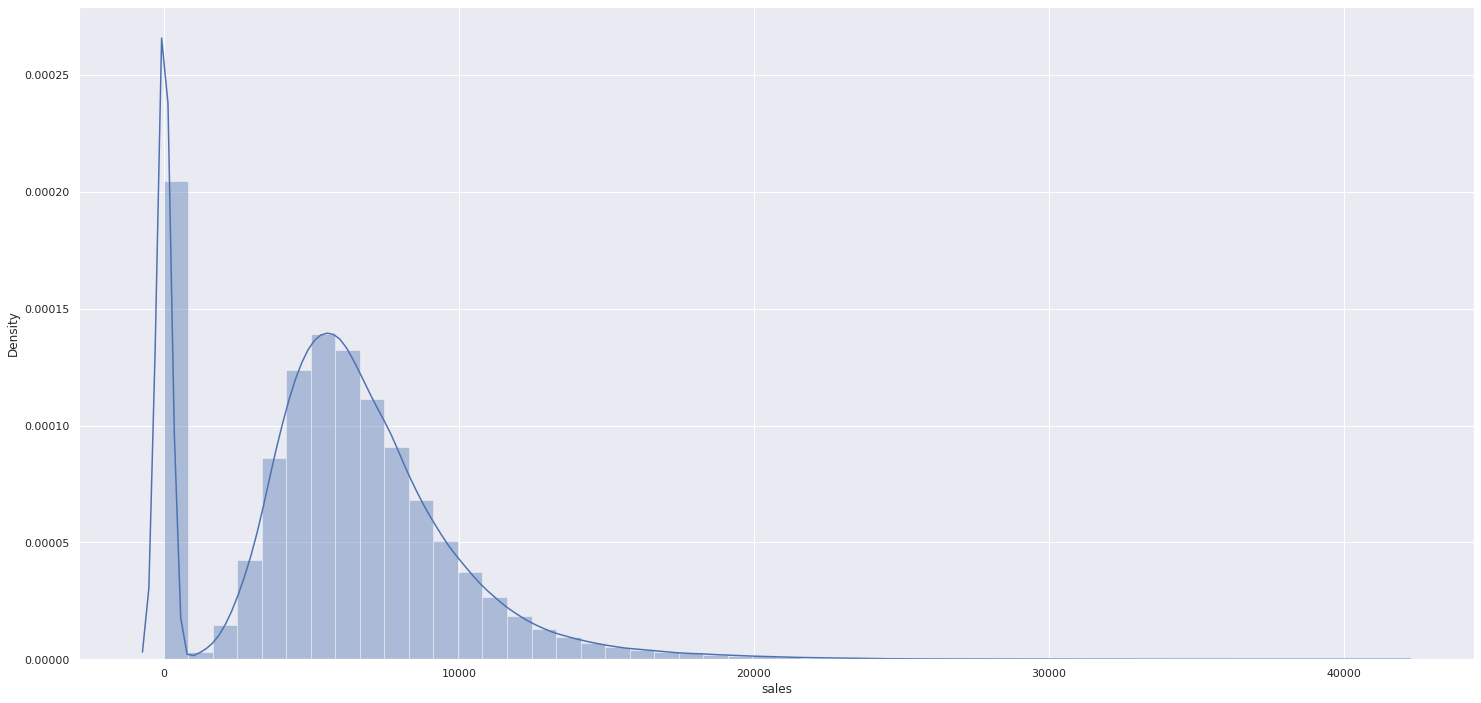

In [23]:
sns.distplot(df1['sales'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


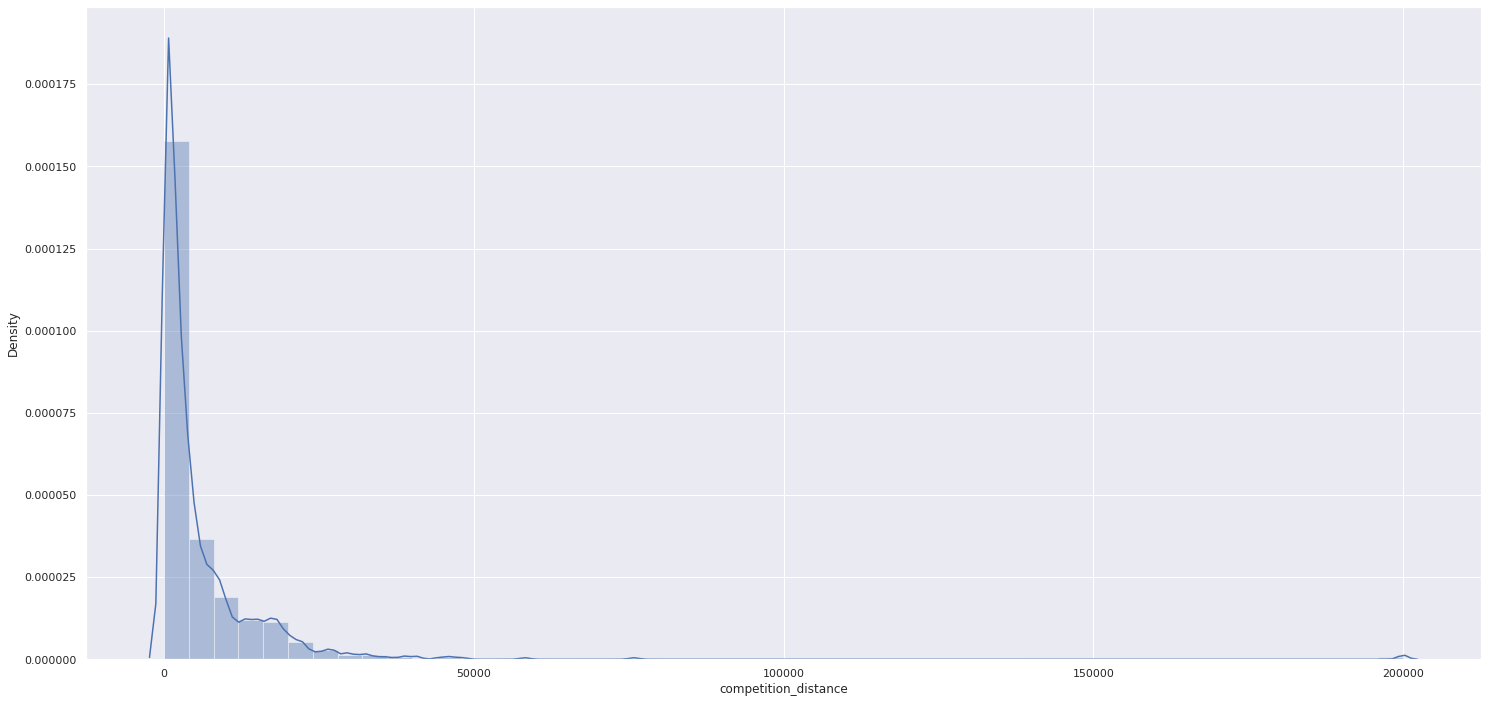

In [24]:
sns.distplot(df1['competition_distance'])

### 1.7.2 Categorical Attributes

In [25]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

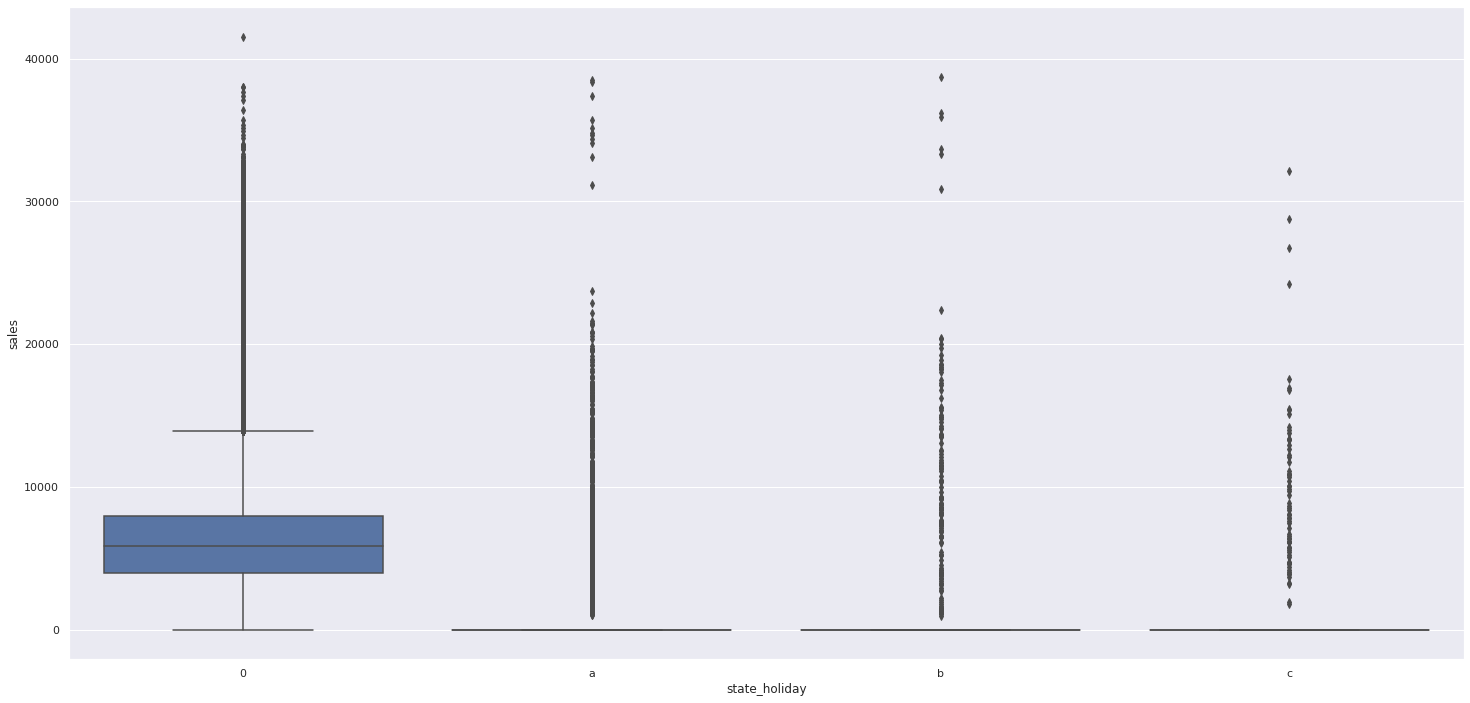

In [26]:
# x =linha que fica como referencia(nome da categoria), y = o que quero medir em cada um dos niveis da variavel categorica 
sns.boxplot(x='state_holiday', y='sales',data=df1)

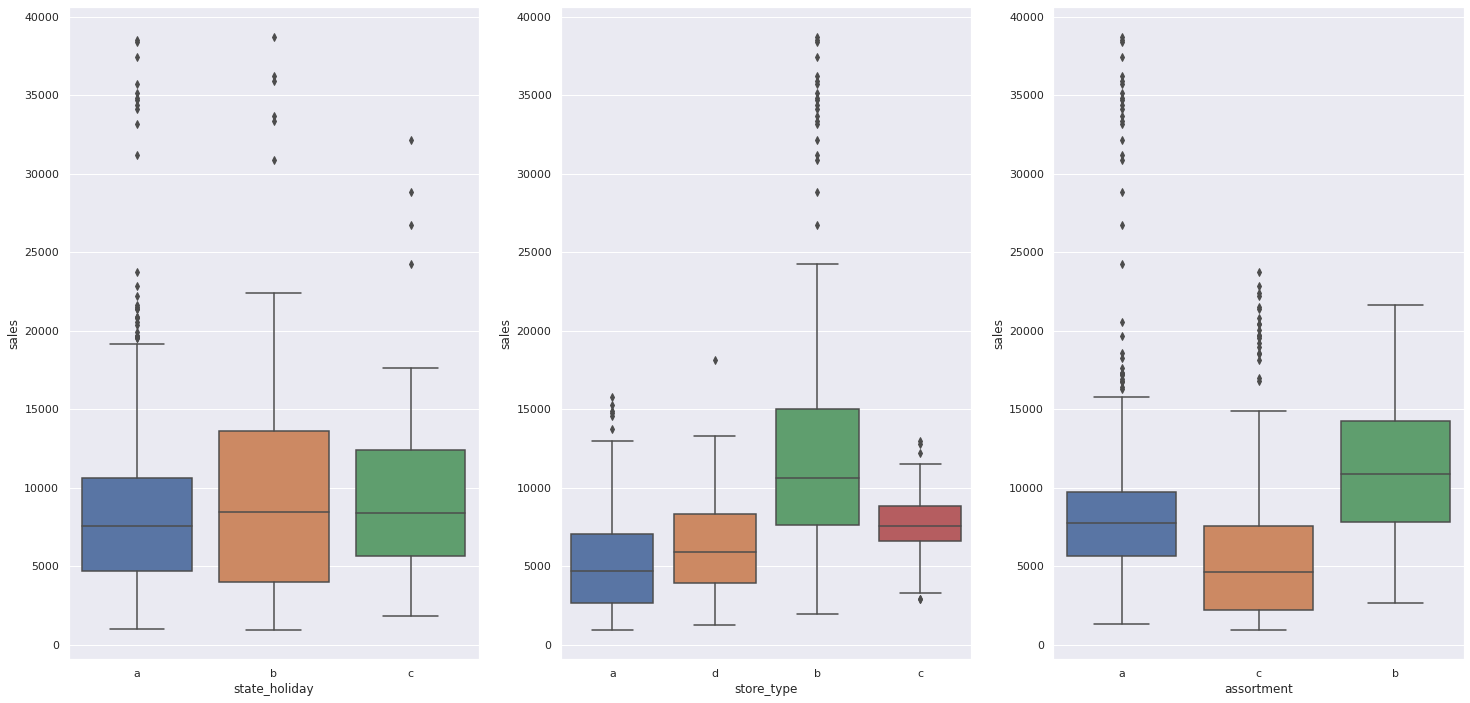

In [27]:
# a imagem acima fica de dificil compreensão por conta que a dimensão das variaveis esta muito diferente ( tem dias que não temvendas por conta das lojas estarem fechadas)
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales']>0)]

plt.subplot(1,3,1)
sns.boxplot(x='state_holiday', y='sales',data=aux1)

plt.subplot(1,3,2)
sns.boxplot(x='store_type', y='sales',data=aux1)

plt.subplot(1,3,3)
sns.boxplot(x='assortment', y='sales',data=aux1)


# 2.0.(Passo 2) FEATURE ENGINEERING

In [28]:
df2 = df1.copy()

## 2.1. Mapa Mental de Hipoteses

In [29]:
Image('img/MindMapHypothesis.png')

## 2.1. Criacao das Hipoteses

### 2.1.1. Hipoteses Loja

**1.** Lojas com maior quadro de funcionarios deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimento deveriam vender mais.

**5.** Lojas com competidores mais proximos deveriam vender menos.

**6.** Lojas com competidores á mais tempo deveriam vender menos.

### 2.1.2. Hipoteses Produto

**1.** Lojas que investem mais em marketing deveriam vender mais.

**2.** Lojas com maior exposicao produtos nas vitrines deveriam vender mais.

**3.** Lojas que tem produtos com precos menores deveriam vender mais.

**4.** Lojas com promocoes mais agressivas (descontos maiores), deveriam vender mais.

**5.** Lojas com promocoes ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promocao deveriam vender mais.

**7.** Lojas com mais promocoes consecutivas deveriam vender mais.

### 2.1.3. Hipoteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos nos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.


## 2.2. Lista final de Hipoteses

In [30]:
#Dando prioridade para as que os dados estão disponiveis

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais proximos deveriam vender menos.

**3.** Lojas com competidores á mais tempo deveriam vender menos.

**4.** Lojas com promocoes ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promocao deveriam vender mais.

**6.** Lojas com mais promocoes consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos nos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3. Feature Engineering

In [31]:
#year
df2['year'] = df2['date'].dt.year
#month
df2['month'] = df2['date'].dt.month
#day
df2['day'] = df2['date'].dt.day
#week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week
#year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')
#competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'],month=x['competition_open_since_month'],day=1),axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)
#promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1','%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)
#assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x =='b' else 'extended')
#state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x =='b' else 'christmas' if x =='c' else 'regular_day')

In [32]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0.(Passo 3) FILTRAGEM DE VARIÁVEIS

In [33]:
df3 = df2.copy()

## 3.1. Filtragem das linhas

In [34]:
#vou filtrar as colunas que open e sales são diferente de 0, pois isso indica que a loja estava fechada e isso pode impactar a previsão
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.1. Selecao de Colunas

In [35]:
# variaveis que não tera valor no monmento da previsão e por esse motivo não irei usar. Open (nesse momento não tera utilidade pois a partir de agora todas as lojas estão abertas)
#customer não terei esse dado no momento da predicao por isso vou excluir
cols_drop=['customers','open','promo_interval','month_map']
df3 = df3.drop(cols_drop,axis=1)

In [36]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0. (Passo 4) ANALISE EXPLORATORIA DOS DADOS


In [37]:
df4 = df3.copy()


## 4.1. Analise Univariada

### 4.1.1. Response Variable

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


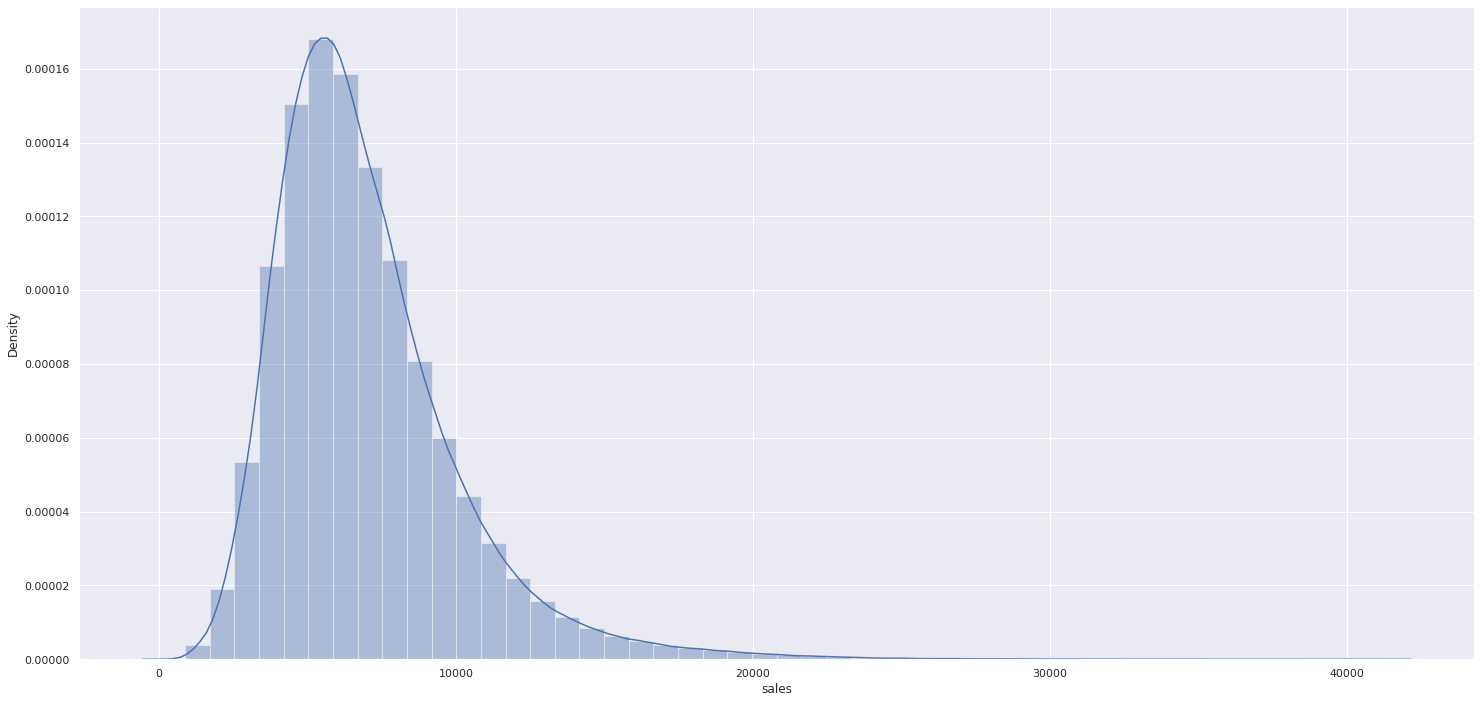

In [38]:
#por que procuramos sempre que a distribuicao seja uma normal, ou parecida com uma? 
#A maioria dos algoritmos de machine learning tem como premissa dados independentes e que sigam a distribuição normal
#existem transformações para se chegar proximo de uma normal como log1p,boxcox,exponencial, etc...
sns.distplot(df4['sales'])
#caso queria tirar a linha em volta do histograma
#sns.distplot(df4['sales'],kde= False)

### 4.1.2. Numerical Variable

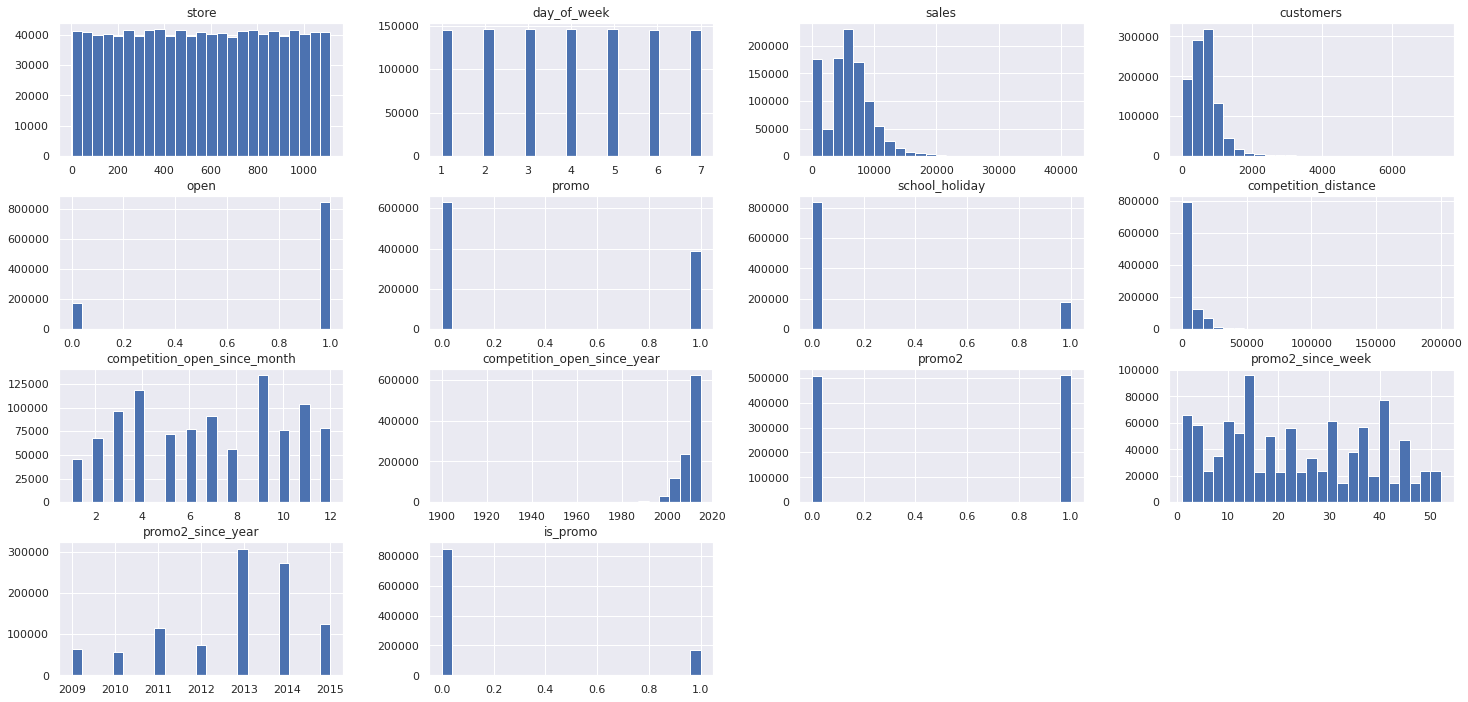

In [39]:
#histograma das variaveis numericas
#bins é cada retangulo
num_attributes.hist(bins =25);

### 4.1.3. Categorical Variable

In [40]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


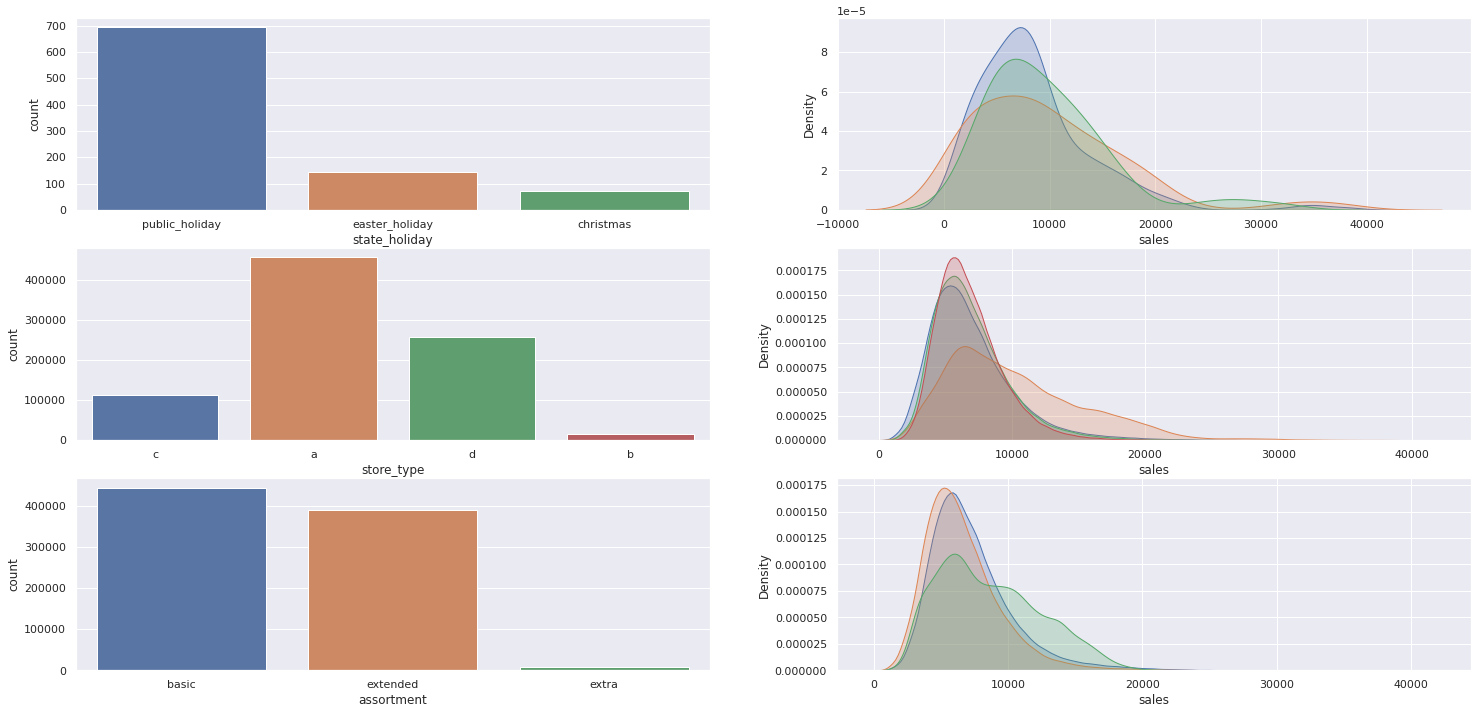

In [41]:
# state_holiday
#exclui regular day pois é a maioria e deixava as outras variaveis parecendo que tinha 0
plt.subplot(3,2,1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] =='public_holiday']['sales'],label='public_holiday',shade=True)
sns.kdeplot(df4[df4['state_holiday'] =='easter_holiday']['sales'],label='easter_holiday',shade=True)
sns.kdeplot(df4[df4['state_holiday'] =='christmas']['sales'],label='public_holiday',shade=True)
#store_type
plt.subplot(3,2,3)

sns.countplot(df4['store_type'])

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] =='a']['sales'],label='a',shade=True)
sns.kdeplot(df4[df4['store_type'] =='b']['sales'],label='b',shade=True)
sns.kdeplot(df4[df4['store_type'] =='c']['sales'],label='c',shade=True)
sns.kdeplot(df4[df4['store_type'] =='d']['sales'],label='d',shade=True)
#assortment
plt.subplot(3,2,5)

sns.countplot(df4['assortment'])

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] =='extended']['sales'],label='extended',shade=True)
sns.kdeplot(df4[df4['assortment'] =='basic']['sales'],label='basic',shade=True)
sns.kdeplot(df4[df4['assortment'] =='extra']['sales'],label='extra',shade=True)


## 4.2. Analise Bivariada

### **H1.** Lojas com maior sortimento deveriam vender mais.



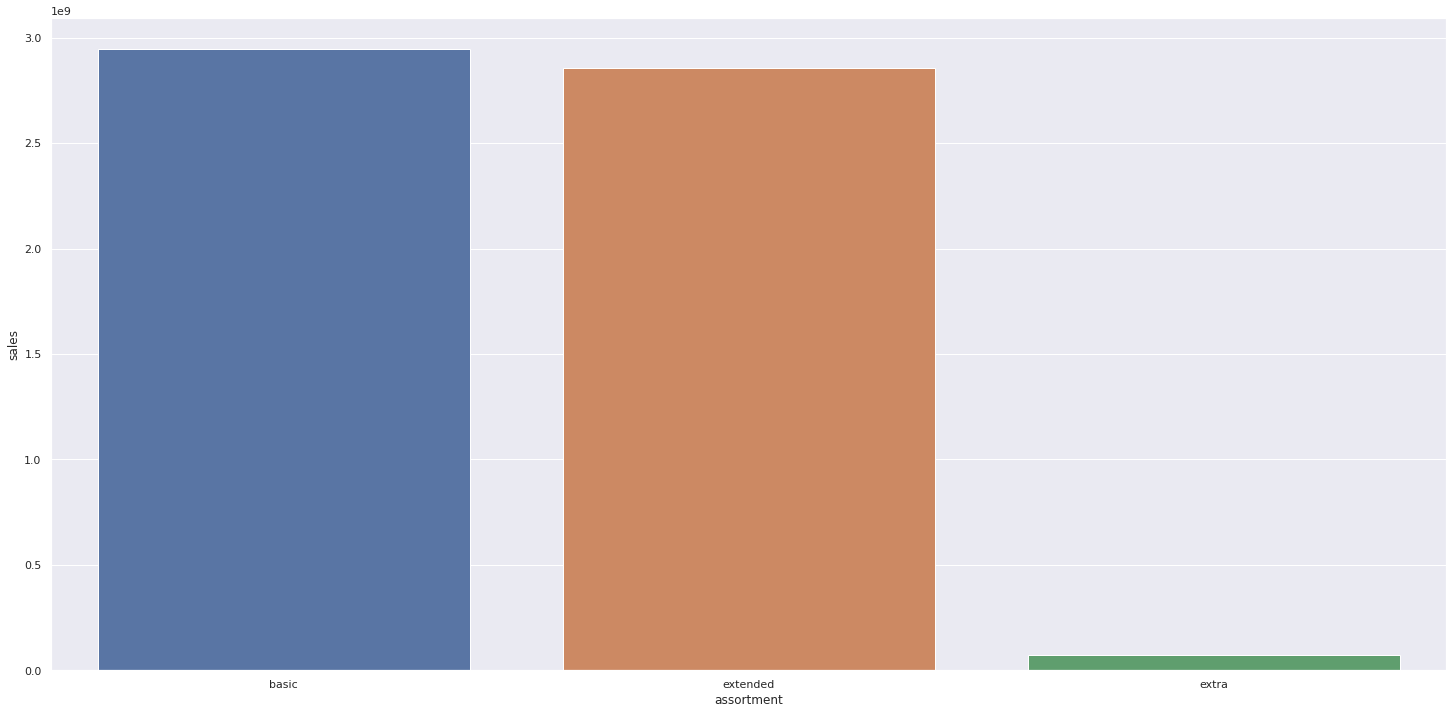

In [42]:
#vamos assumir que o assortment extra significa maior
aux1 = df4[['assortment','sales']].groupby('assortment').sum().reset_index()
sns.barplot(x = 'assortment' , y='sales', data=aux1)

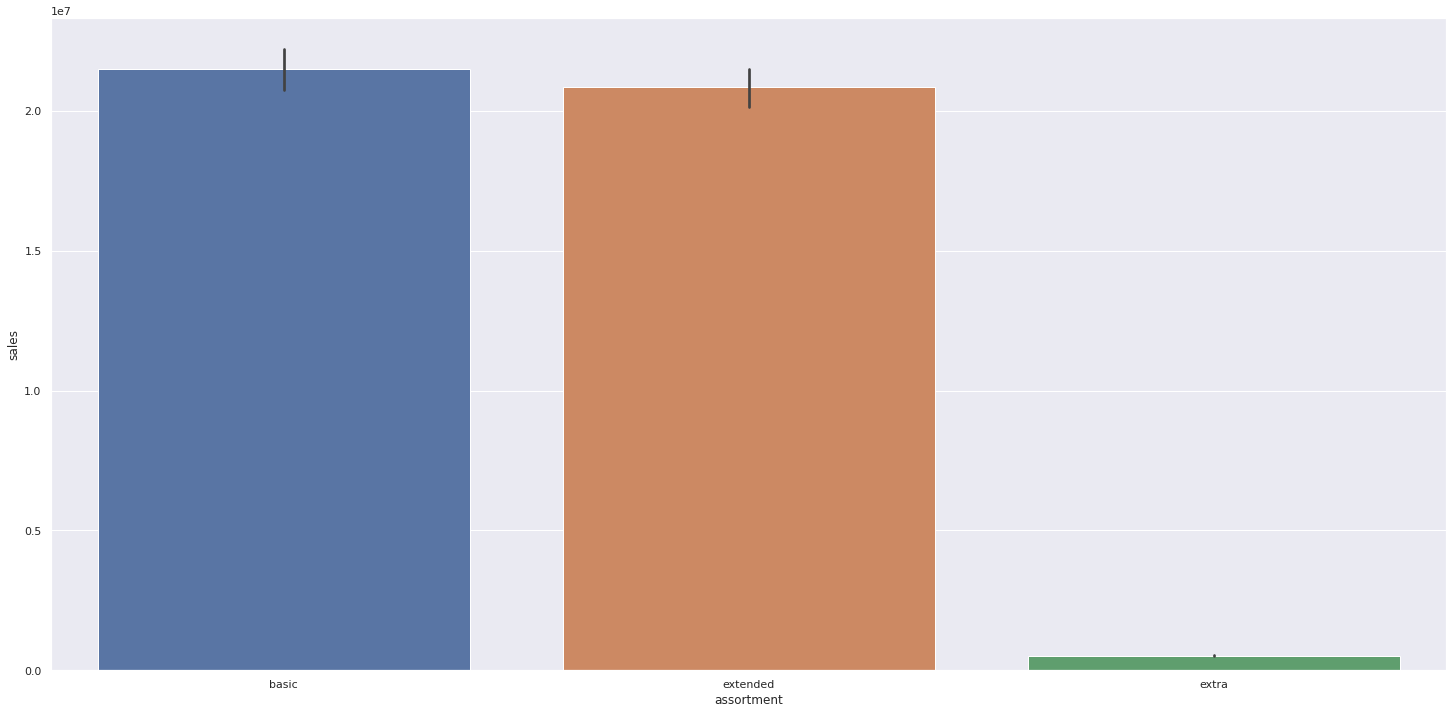

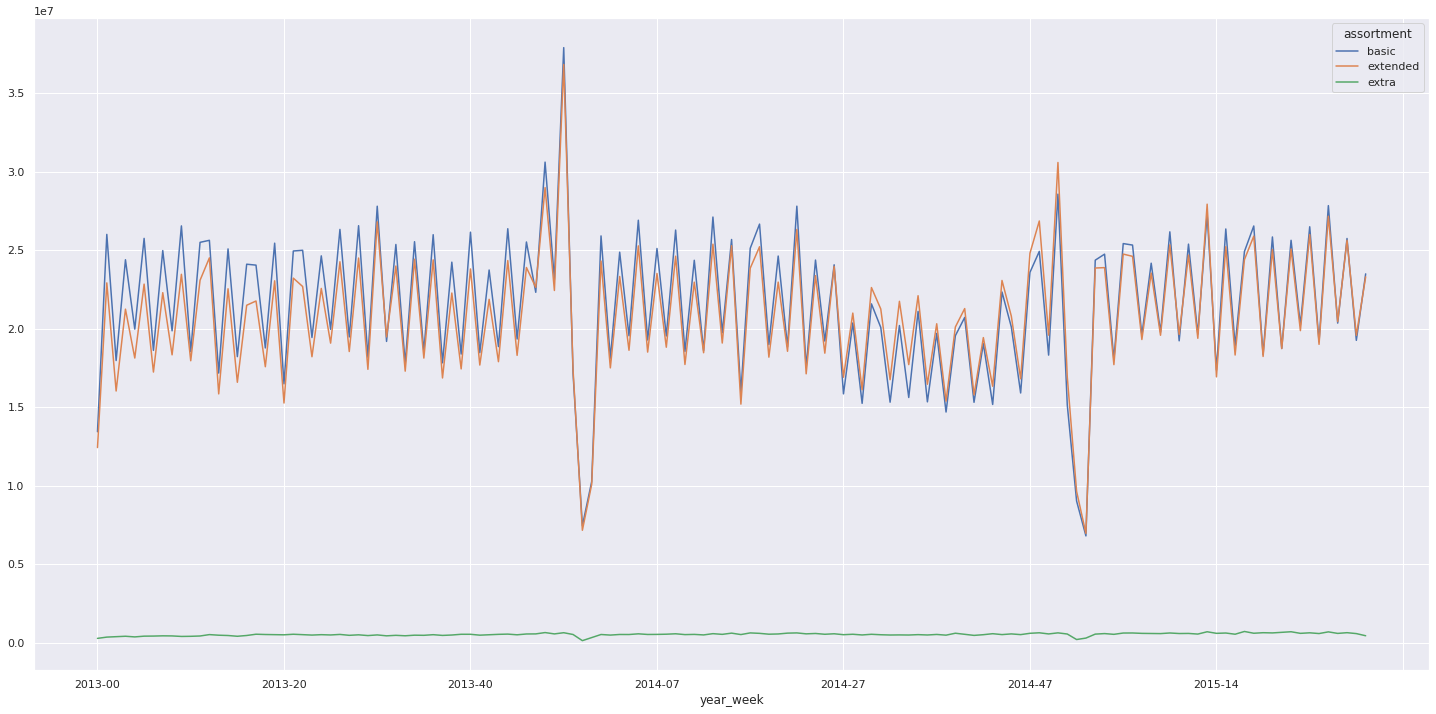

In [43]:
# verificando se o extra foi maior em algum periodo do tempo
aux2 = df4[['year_week','assortment','sales']].groupby(['year_week','assortment']).sum().reset_index()
sns.barplot(x = 'assortment' , y='sales', data=aux2)
aux2.pivot(index = 'year_week', columns = 'assortment', values = 'sales').plot()


In [44]:
# de acordo com os graficos acima pode - se perceber que o volume de venda do basic e extends são praticamente o mesmo(mesmo comportamento) , 
#o volume de extends e basica esta levando a escala muito alto, precisa analisar o extra separadamente para ver o comportamento

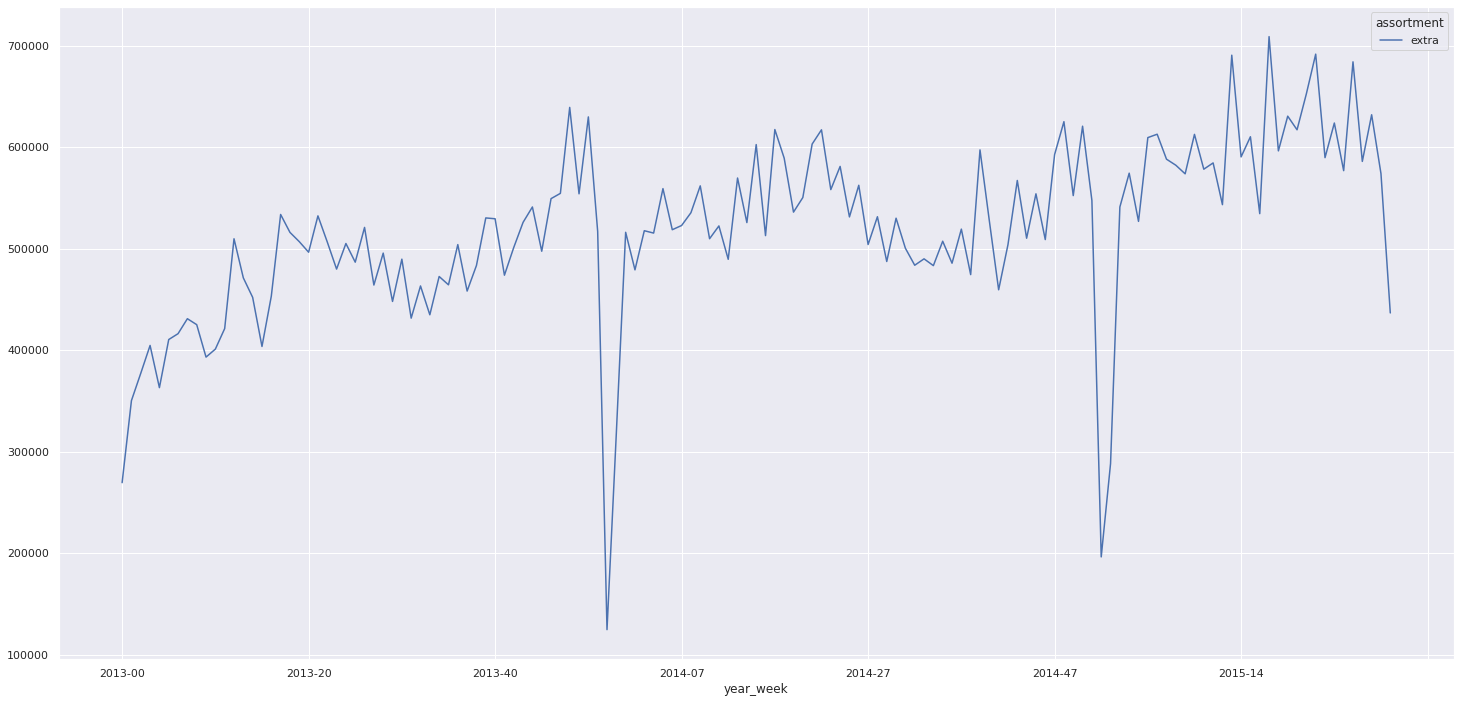

In [45]:
aux3 = aux2[aux2['assortment']=='extra']
aux3.pivot(index='year_week', columns='assortment',values='sales').plot()

In [46]:
# RESPOSTA DA HIPÓTESE: FALSA
# Lojas com maior sortmento vendem MENOS
# a variavel será relevante para o modelo pois o assortment extra não segue o padrão das demais.

### **H2.** Lojas com competidores mais proximos deveriam vender menos.


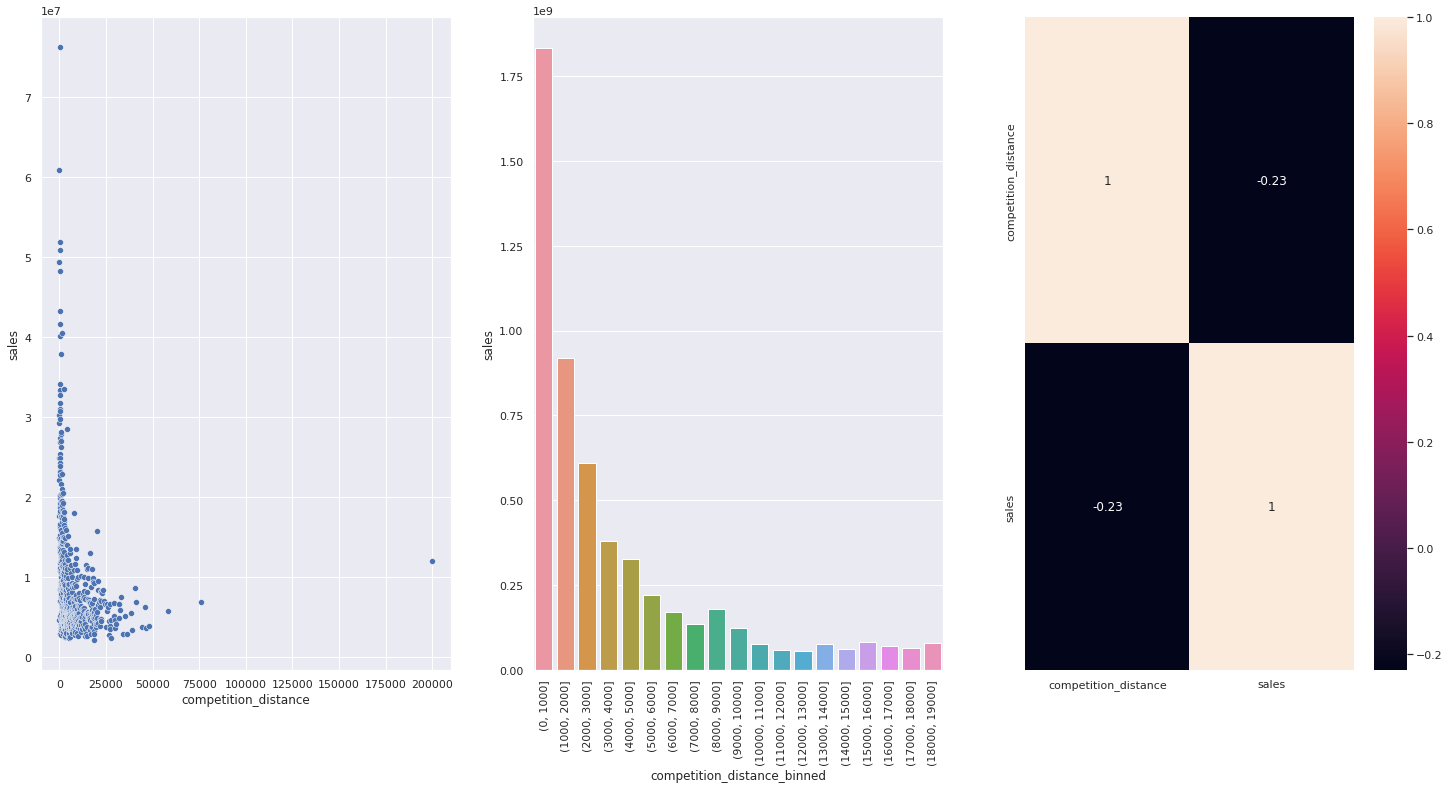

In [47]:
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1,3,1)
#scatterplot
sns.scatterplot(x = 'competition_distance', y='sales', data=aux1);

plt.subplot(1,3,2)
#criando bins pra não poluir o plot
bins = list (np.arange(0,20000,1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'],bins=bins)
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x = 'competition_distance_binned',y ='sales',data = aux2 );
plt.xticks(rotation=90)
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True)


In [48]:
#RESULTADO: FALSE
# Lojas com competidores mais PROXIMOS vendem MAIS
# A correlação mostra que quanto mais distante meu concorrente está, menor a venda.

### **H3.** Lojas com competidores á mais tempo deveriam vender menos.

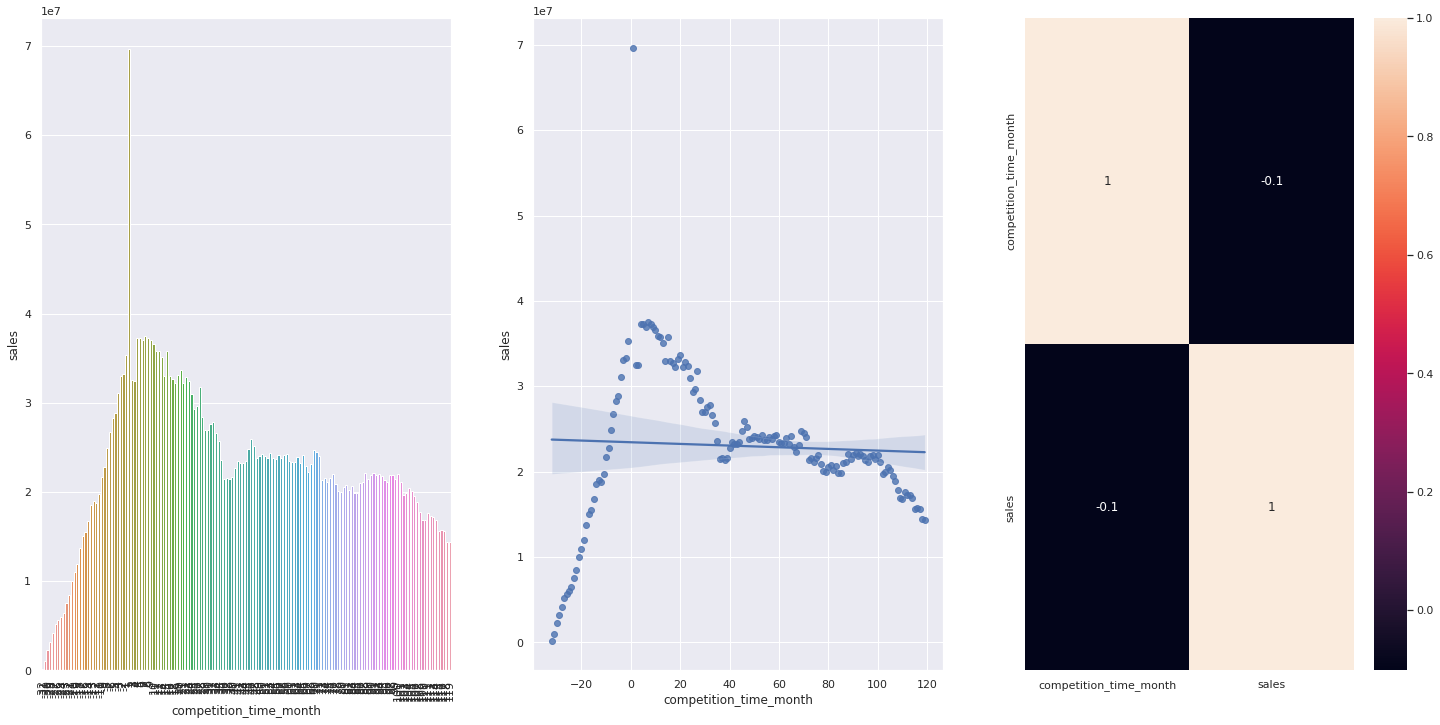

In [49]:
plt.subplot(1,3,1)
aux1 = df4[['competition_time_month','sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] !=0)]
sns.barplot(x = 'competition_time_month', y = 'sales', data=aux2)
plt.xticks(rotation = 90);

plt.subplot(1,3,2)
sns.regplot(x = 'competition_time_month', y = 'sales', data=aux2);

plt.subplot(1,3,3)
x =sns.heatmap(aux1.corr(method='pearson'),annot=True);


In [50]:
#explicacao do grafico 1
#competition_time_month = valor da venda agora(date) - data que o competidor abriu
#valores negativos: quando o competidor ainda não abriu(ex: ele abrirá daqui a 4 meses)
#valores positivos: venda maior (ex: se o competidor abriu 6 meses atrás)
#quanto mais aproxima de 0 maior a venda. Ou seja competições recentes são beneficas para o aumento das vendas 

#explicacao da correlacao
# e uma boa correlacao nao proxima de 0 que seria algo em torno de 0.0..., porém longe de -1 ou 1

In [51]:
# RESULTADO: FALSE

#Lojas com COMPETIDORES a MAIS TEMPO vendem  MENOS

### **H4.** Lojas com promocoes ativas por mais tempo deveriam vender mais.


In [52]:
df4.head()
#existe 2 periodos promocionais - o tradicional e o extendido. se for negativo , a compra foi feita na promocao tradicional, caso seja positivo foi no periodo da promo2(extendida)
#a promo2 é opcional para a loja

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


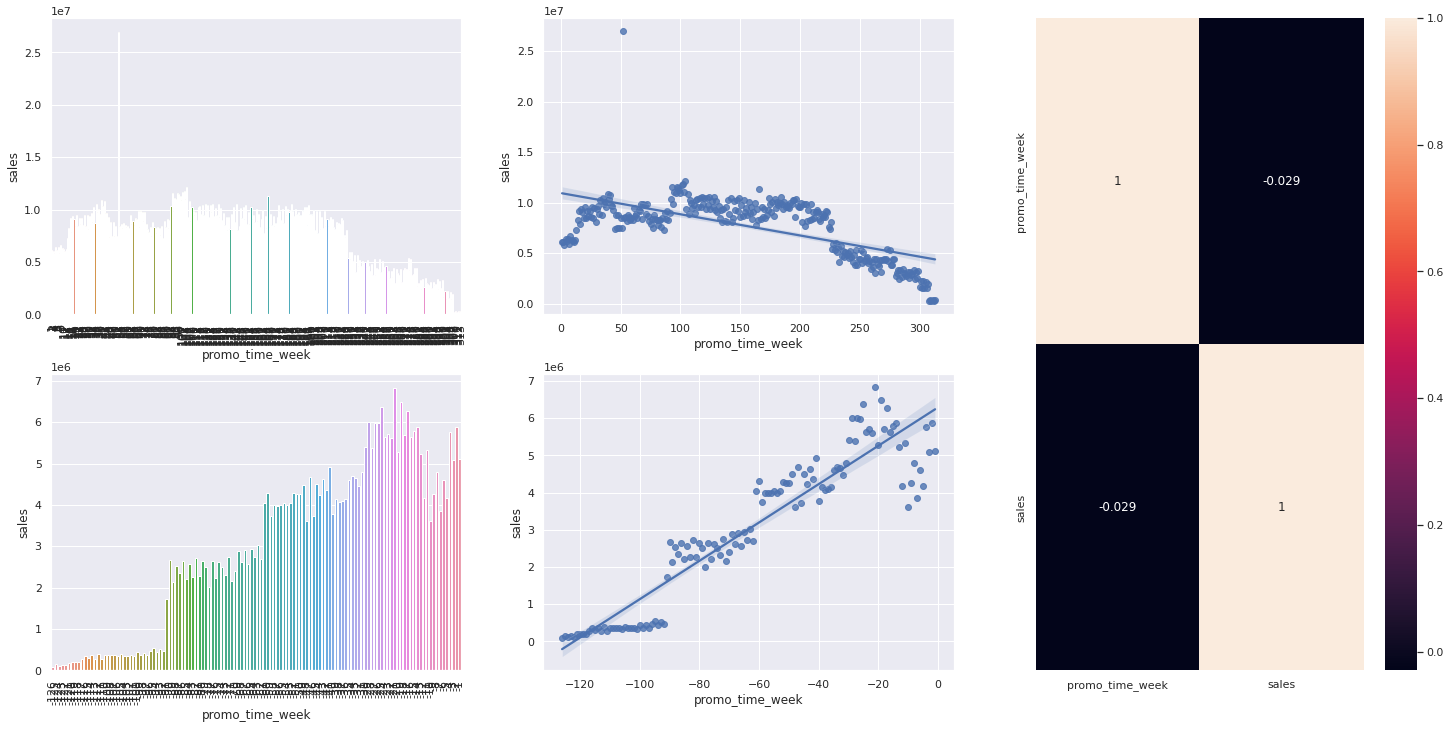

In [53]:
aux1 = df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()

grid =GridSpec(2,3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week']> 0] # periodo extendido
sns.barplot(x = 'promo_time_week' , y='sales', data=aux2);
plt.xticks(rotation = 90);

#grafico de tendencia
plt.subplot(grid[0,1])
sns.regplot(x = 'promo_time_week' , y='sales', data=aux2);

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week']< 0] # periodo regular
sns.barplot(x = 'promo_time_week' , y='sales', data=aux3);
plt.xticks(rotation = 90);

#grafico de tendencia
plt.subplot(grid[1,1])
sns.regplot(x = 'promo_time_week' , y='sales', data=aux3);

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'),annot= True);

In [54]:
# a variavel é relevante para o modelo?
# tem um comportamento relevante, pois é possivel ver que no periodo promocional as vendas se mantem constantes ate um certo ponto
# e no periodo regular nota-se um atraso até que as vendas crescam, tlvz influenciado por alguma ação de marketing?

In [55]:
# RESPOSTA: FALSA
# Lojas com promocoes ativas por mais tempo vendem menos, depois de um certo periodo de promocao
# a correlacao se mostrou fraquissima.Mostra-se a principio irrelevante para o modelo. Porém pode ser que combinada com outra variavel produza algum efeito, a ser validado mais adiante.

### **H5.** Lojas com mais dias de promocao deveriam vender mais.


In [56]:
#hipotese parecida com a anterior. Deverá ser abordada no proximo ciclo do crisp

### **H6.** Lojas com mais promocoes consecutivas deveriam vender mais.

In [57]:
df4[['promo','promo2','sales']].groupby(['promo','promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


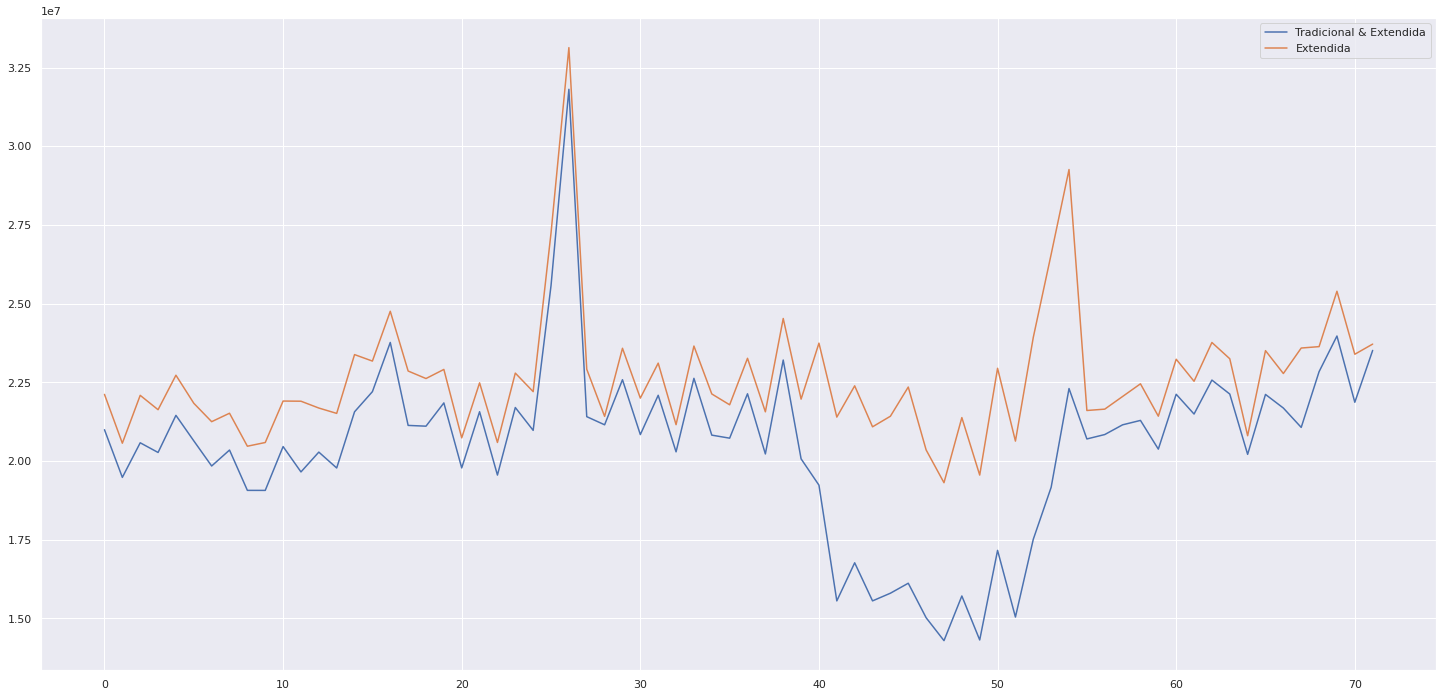

In [58]:
aux1 = df4[(df4['promo']==1) & (df4['promo2']==1)][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo']==1) & (df4['promo2']==0)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['Tradicional & Extendida','Extendida']);

In [59]:
# lojas com promoções consecutivas não vendem mais(linha azul)
# basicamente o comportamento é o mesmo das curvas, apenas em um momento que isso nao é observado. 
#Em linhas gerais, não influencia o modelo. Deve-se ver se em conjunto com outra variavel ela se torna relevante

In [60]:
#RESPOSTA: FALSA
#Lojas com promoções consecutivas vendem menos

## 4.3. Analise Multivariada



### **H7.** Lojas abertas durante o feriado de Natal deveriam vender mais.


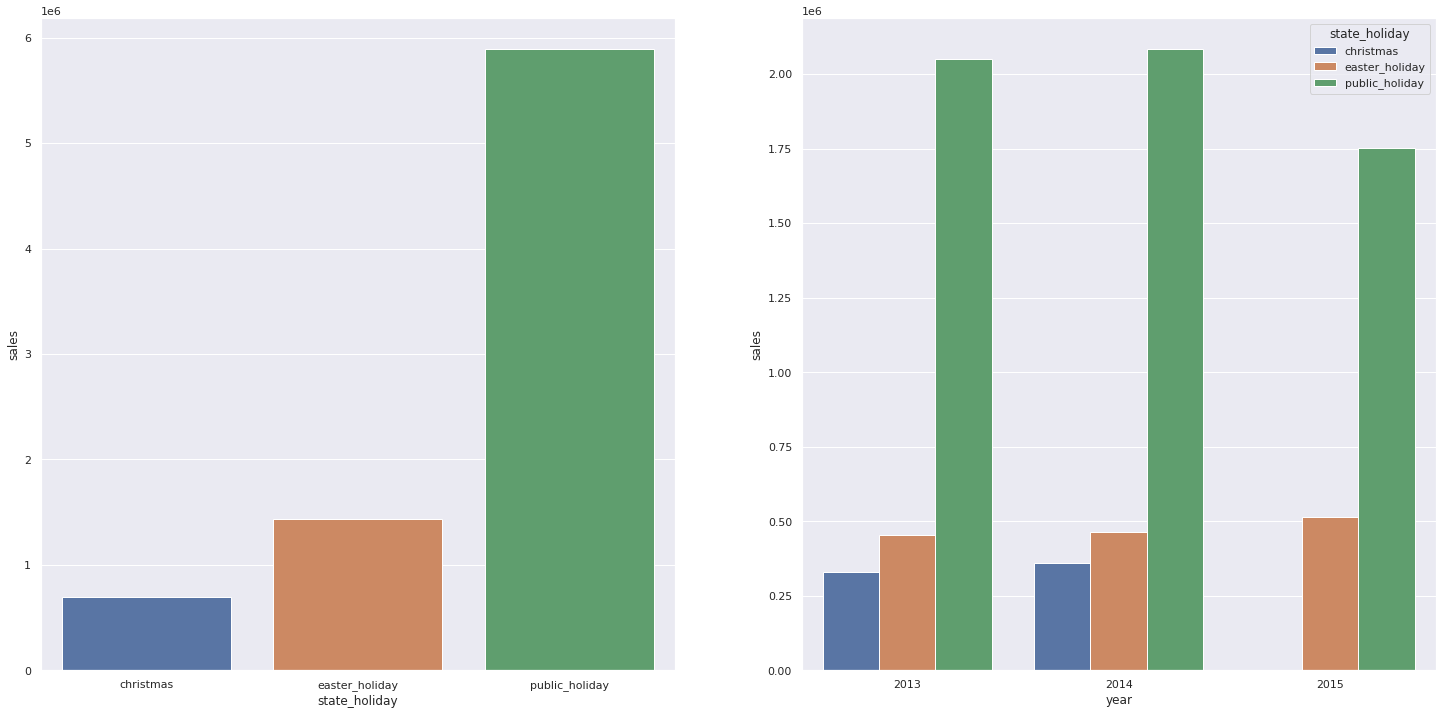

In [61]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1,2,1)
aux1 = aux[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x = 'state_holiday' ,y ='sales', data = aux1);

plt.subplot(1,2,2)
#vendo se natal ja vendeu mais que os outros feriados
aux2 = aux[['year','state_holiday','sales']].groupby(['year','state_holiday']).sum().reset_index()
#hue = tipos de barras ( para cada state_holiday quero uma barra)
sns.barplot( x = 'year', y = 'sales', hue = 'state_holiday', data = aux2);

In [62]:
# RESPOSTA DA HIPÓTESE: FALSA
# Lojas abertas durante o feriado do natal vendem menos

### **H8.** Lojas deveriam vender mais ao longo dos anos.

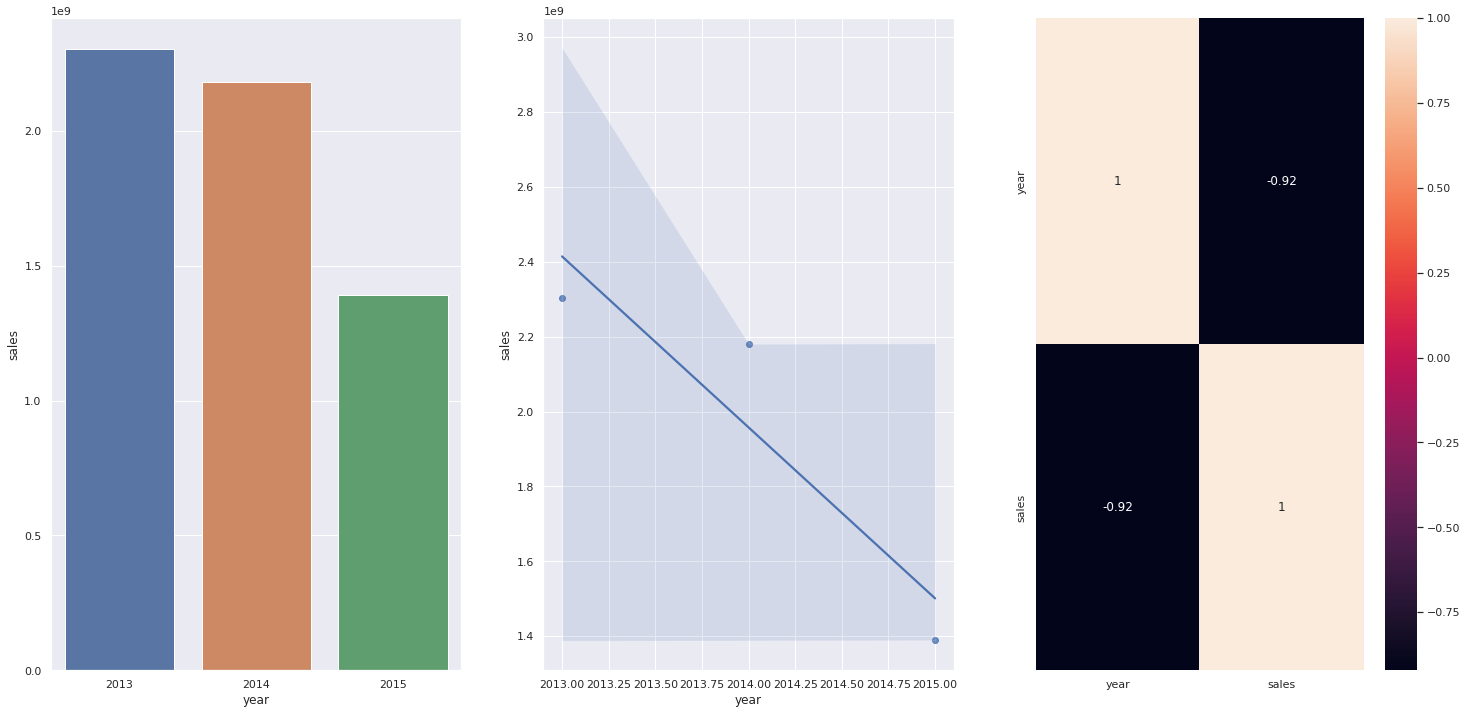

In [63]:
aux1 = df4[['year','sales']].groupby('year').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x = 'year', y ='sales', data = aux1);

plt.subplot(1,3,2)
#tendencia
sns.regplot(x = 'year', y ='sales', data = aux1);

plt.subplot(1,3,3)
#correlacao
sns.heatmap(aux1.corr( method='pearson'),annot =True);

In [64]:
# correlacao muito forte negativamente - Conforme os anos passam as vendas caem. (2015 não é um ano completo, pode interferir...)
#é um indicio que ano é importante para o modelo

In [65]:
# RESPOSTA DA HIPÓTESE: FALSA
# Lojas  vendem menos ao longo dos anos

### **H9.** Lojas deveriam vender mais no segundo semestre do ano.


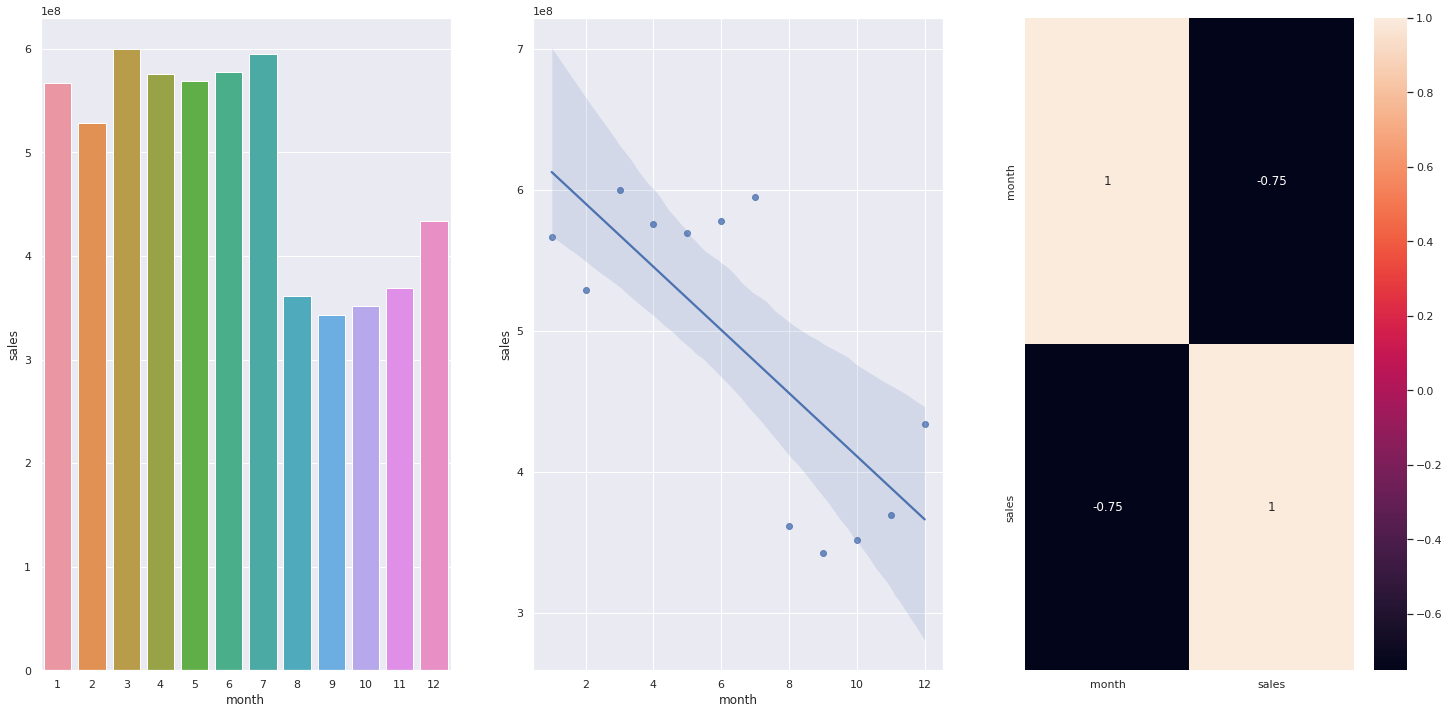

In [66]:
aux1 = df4[['month','sales']].groupby('month').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x = 'month', y ='sales', data = aux1);

plt.subplot(1,3,2)
#tendencia
sns.regplot(x = 'month', y ='sales', data = aux1);

plt.subplot(1,3,3)
#correlacao
sns.heatmap(aux1.corr( method='pearson'),annot =True);

In [67]:
# as lojas vendem menos no segundo semestre
#importante para o modelo

In [68]:
# RESPOSTA DA HIPÓTESE: FALSA
# Lojas  vendem menos no segundo semestre do ano

### **H10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

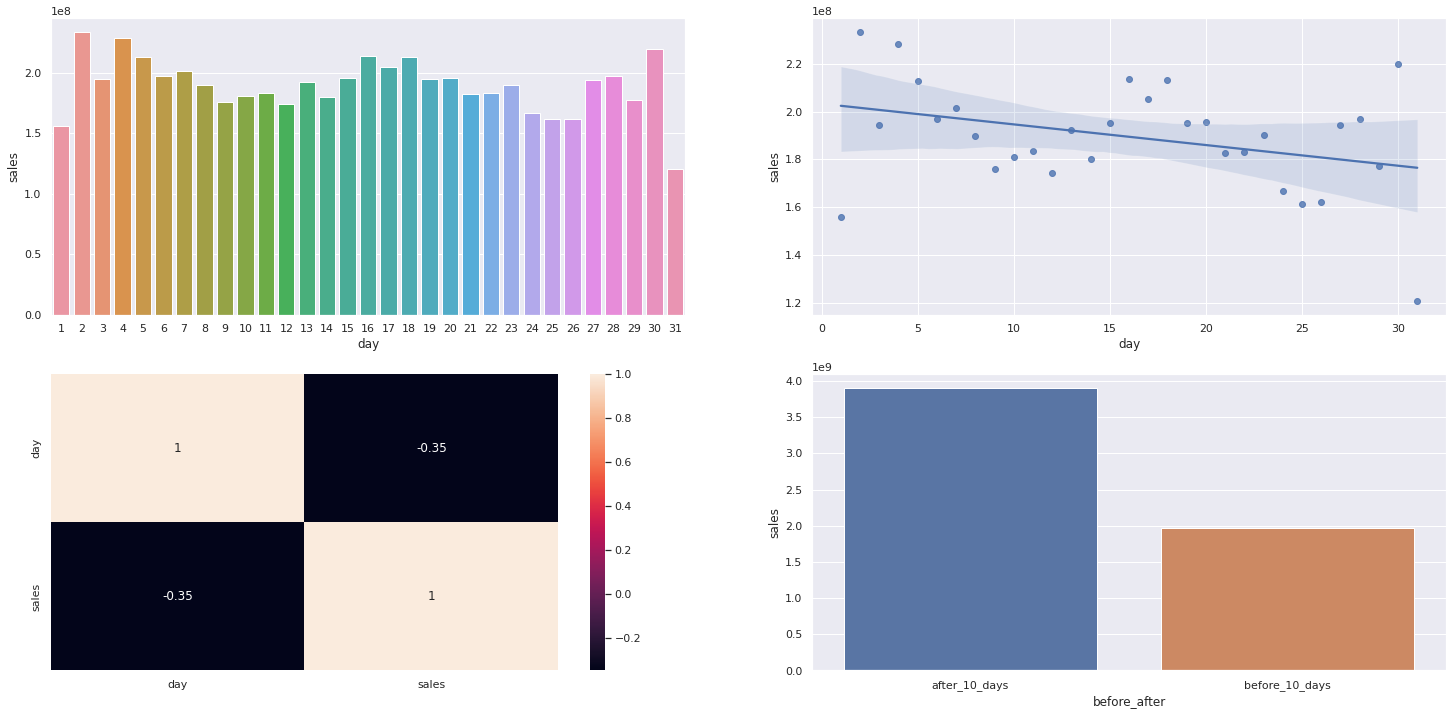

In [69]:
aux1 = df4[['day','sales']].groupby('day').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x = 'day', y ='sales', data = aux1);

plt.subplot(2,2,2)
#tendencia
sns.regplot(x = 'day', y ='sales', data = aux1);

plt.subplot(2,2,3)
#correlacao
sns.heatmap(aux1.corr( method='pearson'),annot =True);


aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x<=10 else 'after_10_days')
aux2 = aux1[['before_after','sales']].groupby('before_after').sum().reset_index()

plt.subplot(2,2,4)
sns.barplot(x='before_after',y='sales', data=aux2);

In [70]:
# RESPOSTA DA HIPÓTESE: TRUE
# Lojas  vendem mais depois do dia 10

### **H11.** Lojas deveriam vender menos nos finais de semana.

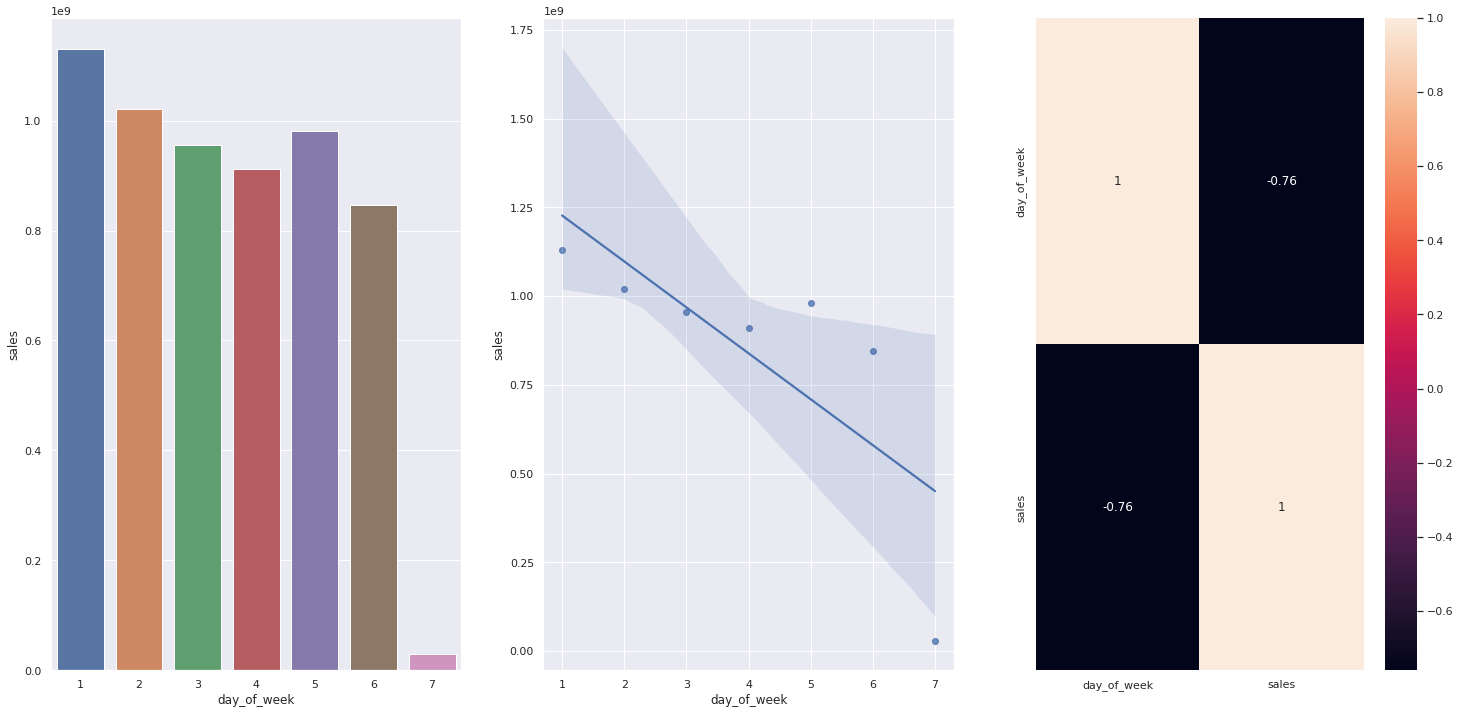

In [71]:
aux1 = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x = 'day_of_week', y ='sales', data = aux1);

plt.subplot(1,3,2)
#tendencia
sns.regplot(x = 'day_of_week', y ='sales', data = aux1);

plt.subplot(1,3,3)
#correlacao
sns.heatmap(aux1.corr( method='pearson'),annot =True);



In [72]:
# RESPOSTA DA HIPÓTESE: TRUE
# Lojas  vendem menos nos finais de semana

### **H12.** Lojas deveriam vender menos durante os feriados escolares.

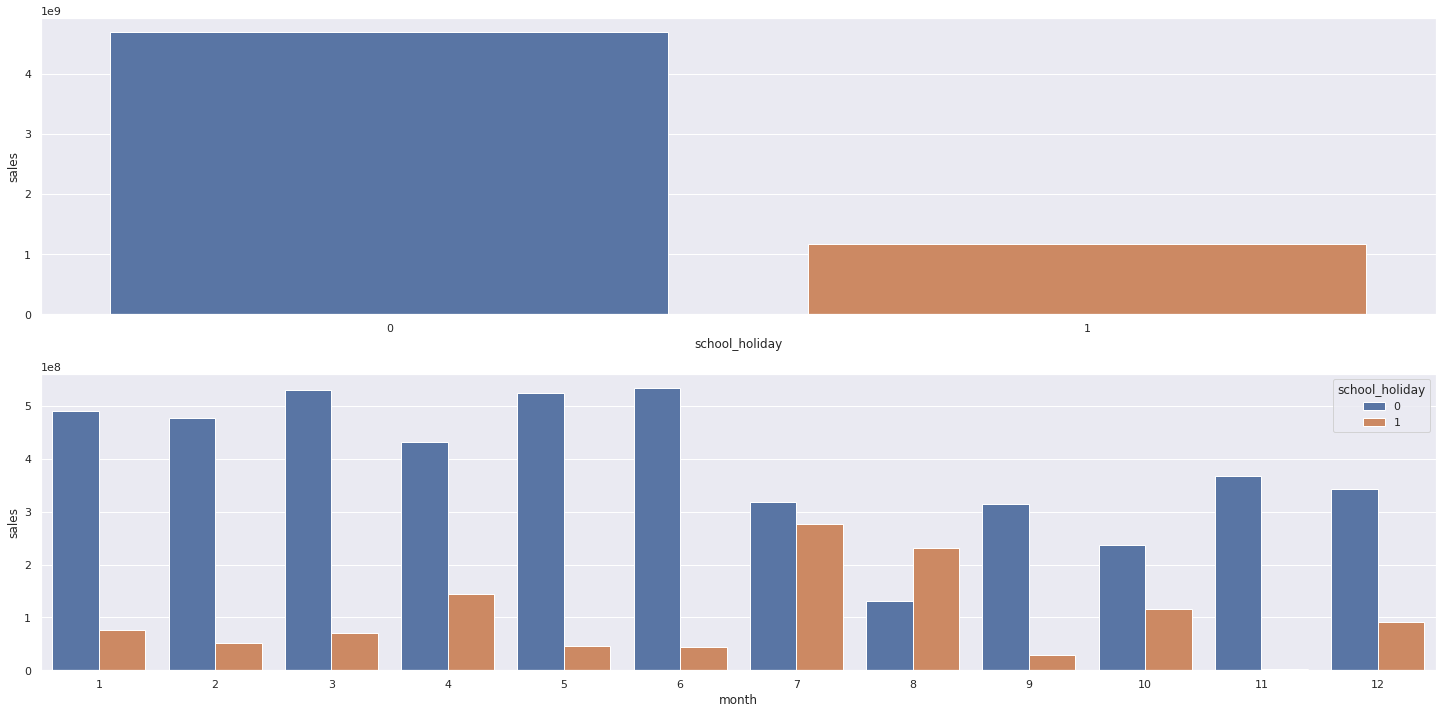

In [73]:
aux1 = df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()

plt.subplot(2,1,1)
sns.barplot(x = 'school_holiday', y ='sales', data = aux1);

plt.subplot(2,1,2)
aux2 = df4[['month','school_holiday','sales']].groupby(['month','school_holiday']).sum().reset_index()
sns.barplot(x = 'month', y ='sales', hue = 'school_holiday', data = aux2);

In [74]:
# RESPOSTA DA HIPÓTESE: TRUE
# Lojas  vendem menos nos feriados escolares exceto os meses de Julho e Agosto

### 4.3.1 Numerical Atributes

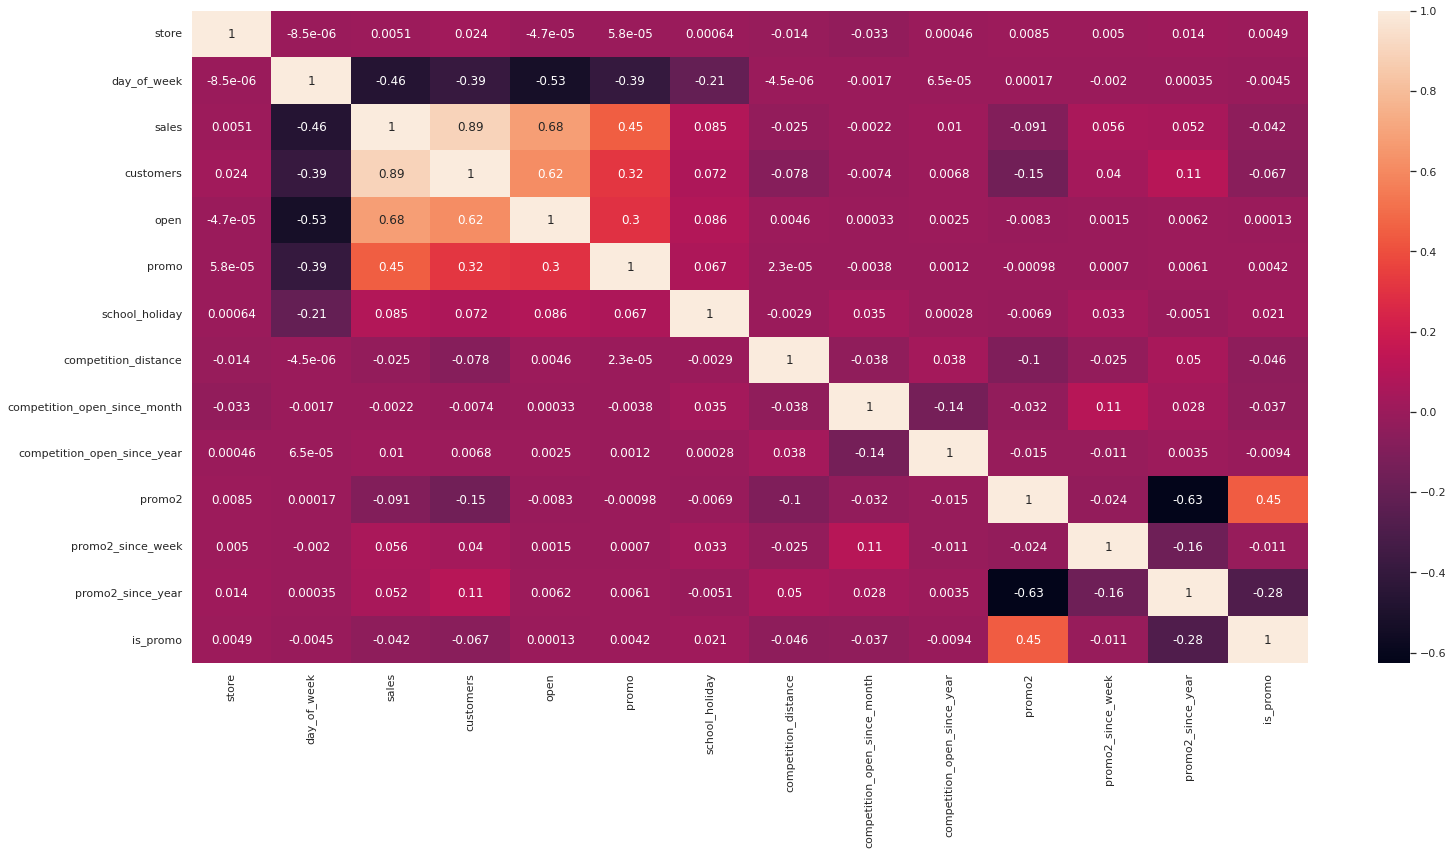

In [75]:
correlation = num_attributes.corr(method = 'pearson')
sns.heatmap(correlation,annot = True)

### 4.3.2 Categorical Atributes

In [76]:
# correlação entre duas variaveis categoricas não se usa pearson e sim cramer V

In [77]:
# only categorical data
a = df4.select_dtypes(include = 'object')

In [78]:
a.head()
#year_week esta como objeto mas é data, então será excluido
# em python tem que implementar a formula na mão . Em R tem pronta

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


In [79]:
#matrix de confusao
cm = pd.crosstab( a['state_holiday'], a['store_type']).values

In [80]:
#calculate Cramer v 
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

#Final Dataset
d = pd.DataFrame({'state_holiday':[a1, a2, a3],
                  'store_type':[a4, a5, a6],
                  'assortment':[a7, a8, a9],           
                })
d = d.set_index(d.columns)

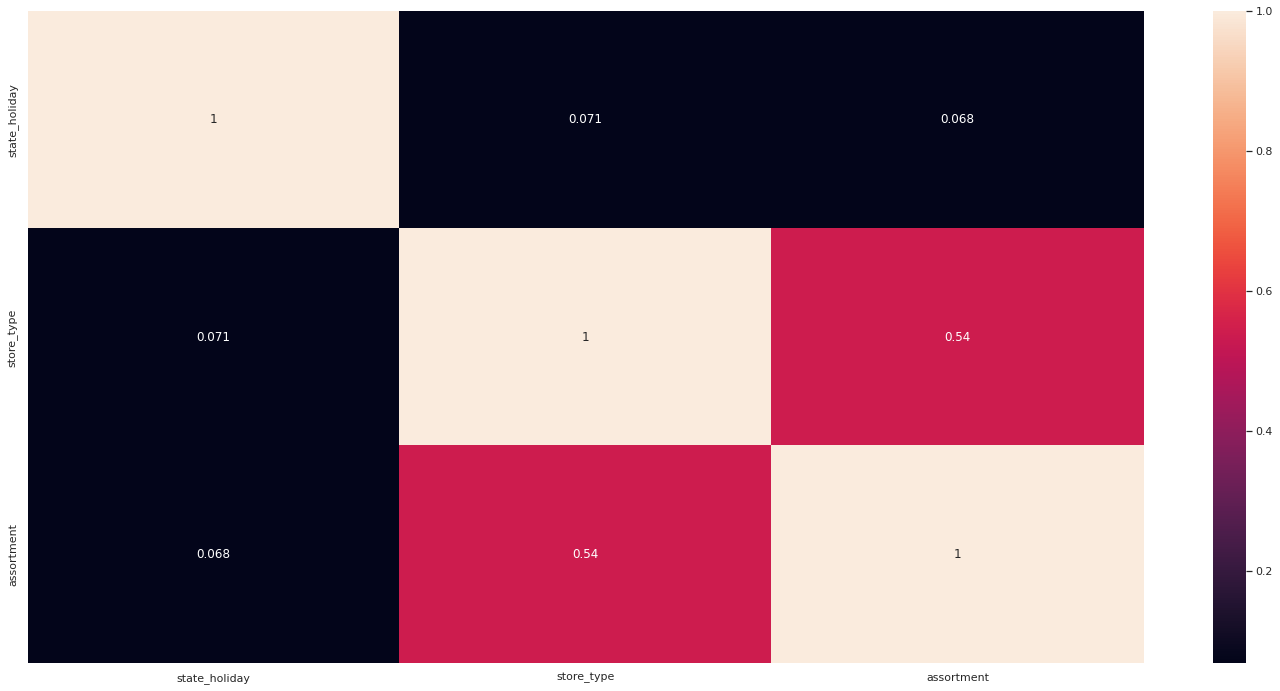

In [81]:
sns.heatmap(d,annot = True)


# 5.0. (Passo 5) DATA PREPARATION

In [82]:
df5 = df4.copy()

## 5.1 Normalizacao

In [83]:
# para ver quais variaveis serão normalizadas, devemos ver a normal das variaveis. Como ja foi feito na secao 4.1.2 nao precisa fazer novamente. 
#Lá vemos que nenhuma variavel segue a distribuicao normal. Portanto ese passo nao sera feito

## 5.2 Rescaling


In [84]:
a = df5.select_dtypes(include =['int64','float64'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


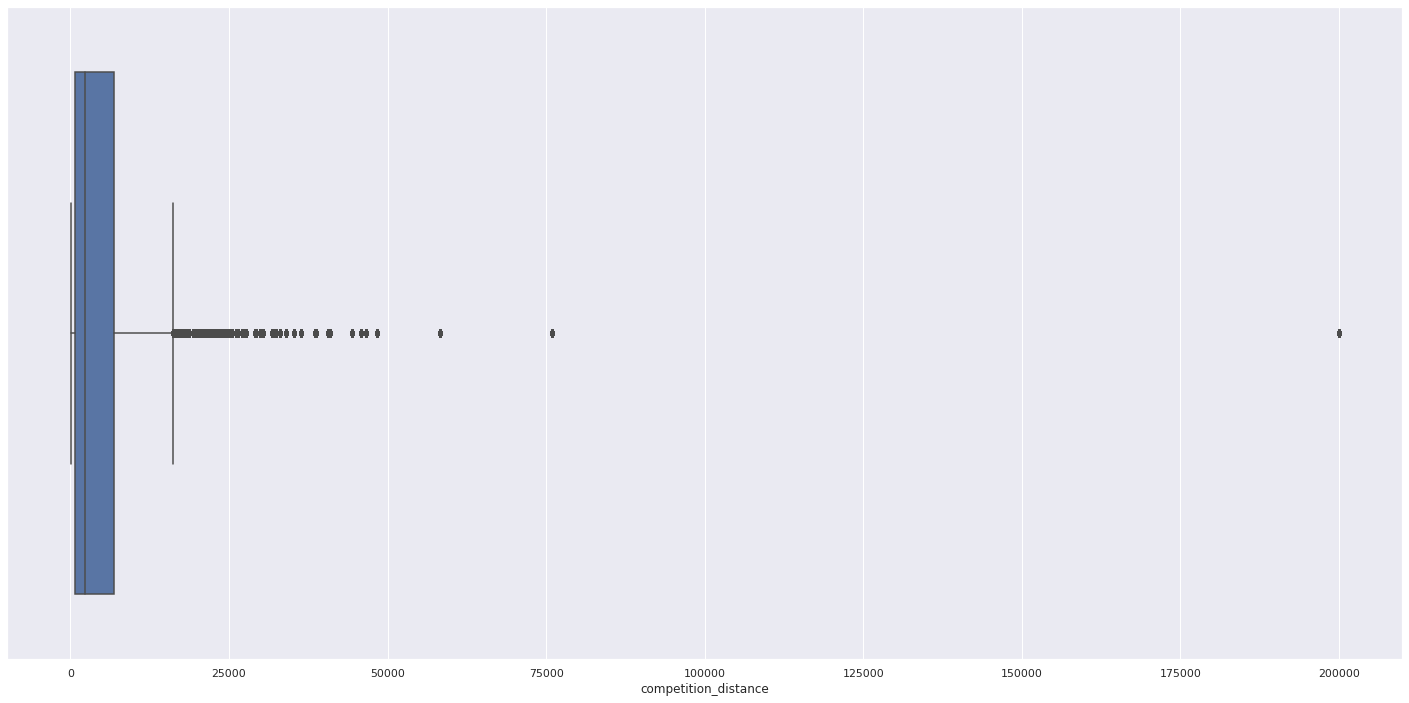

In [85]:
#outliers bem definidos em competition_distance - usar robust scaler
sns.boxplot(df5['competition_distance'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


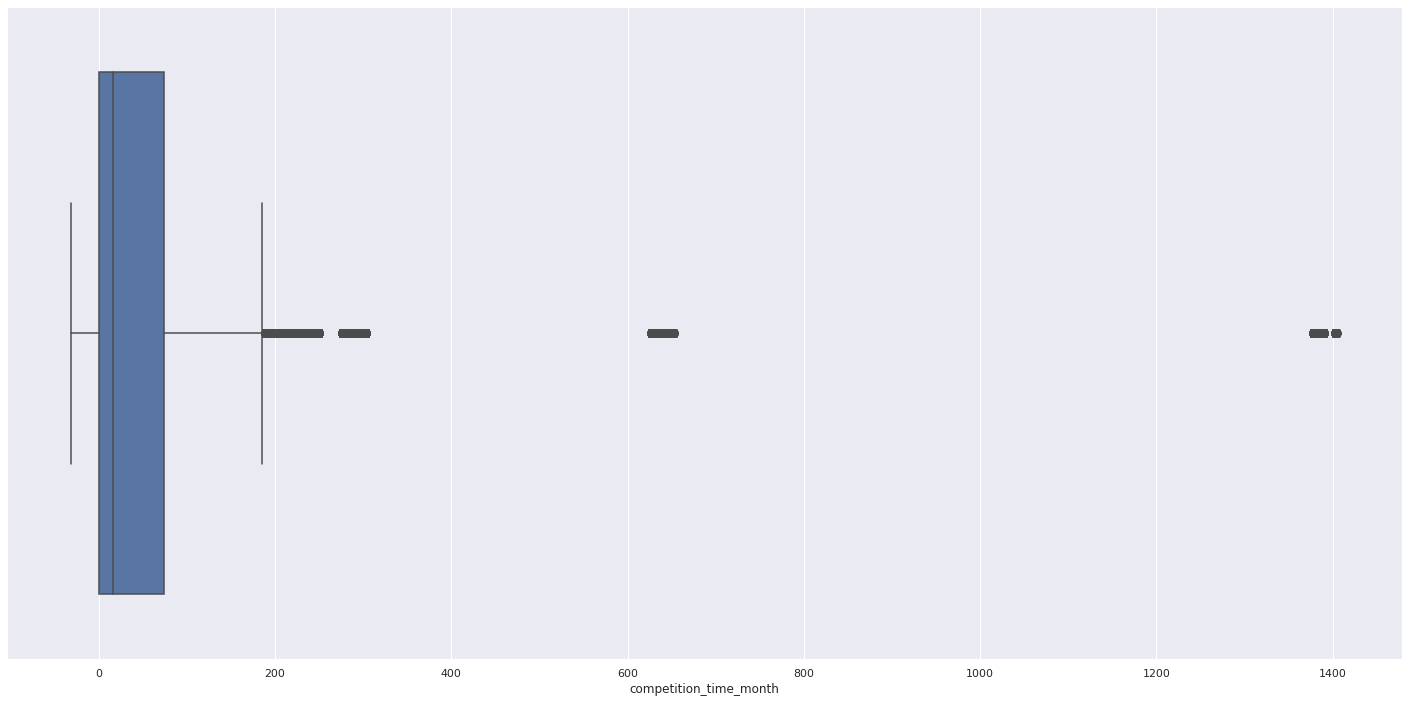

In [86]:
#outliers bem definidos em competition_time_month - usar robust scaler
sns.boxplot(df5['competition_time_month'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


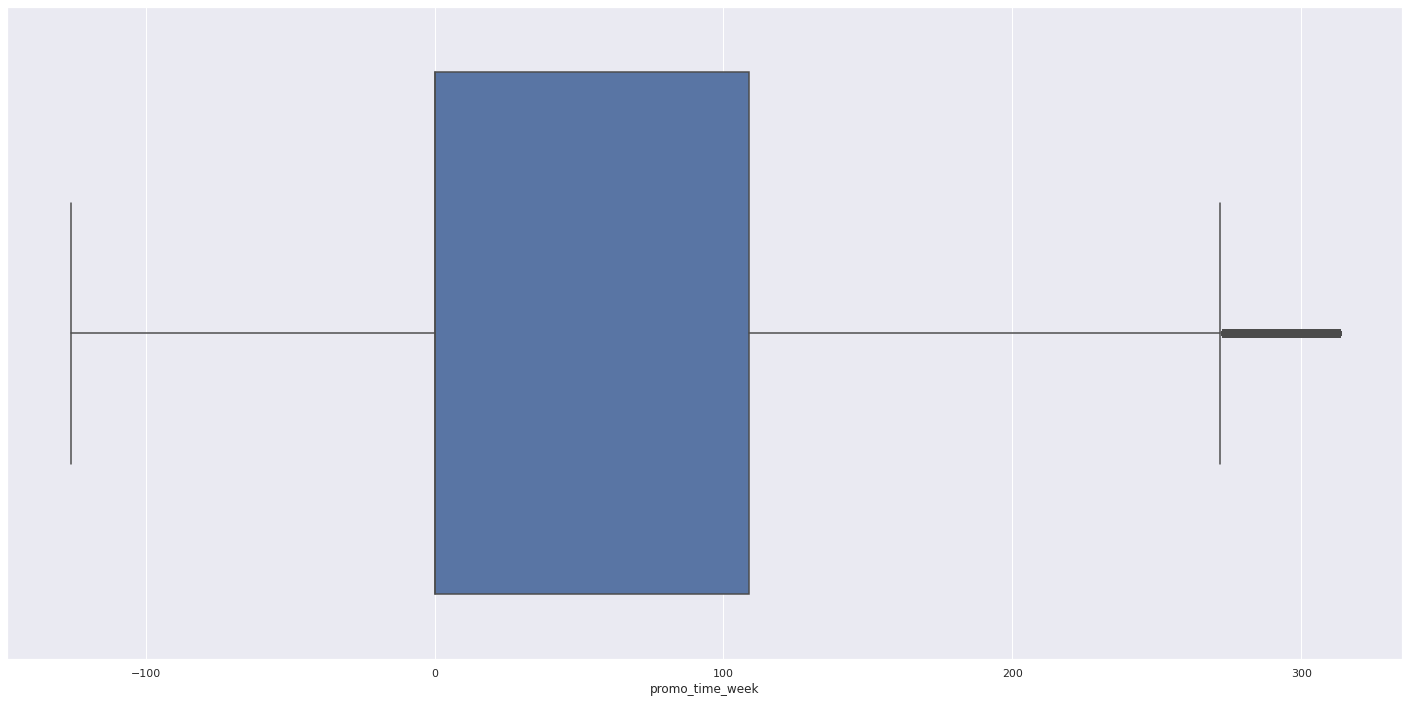

In [87]:
#outliers bem definidos em promo_time_week - outliers não são tão relevantes aqui, então será usado Min-Max Scaler
sns.boxplot(df5['promo_time_week'])

In [88]:
rs = RobustScaler()
mms = MinMaxScaler()
#competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
#competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
#promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
#year
df5['year'] = mms.fit_transform(df5[['year']].values)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


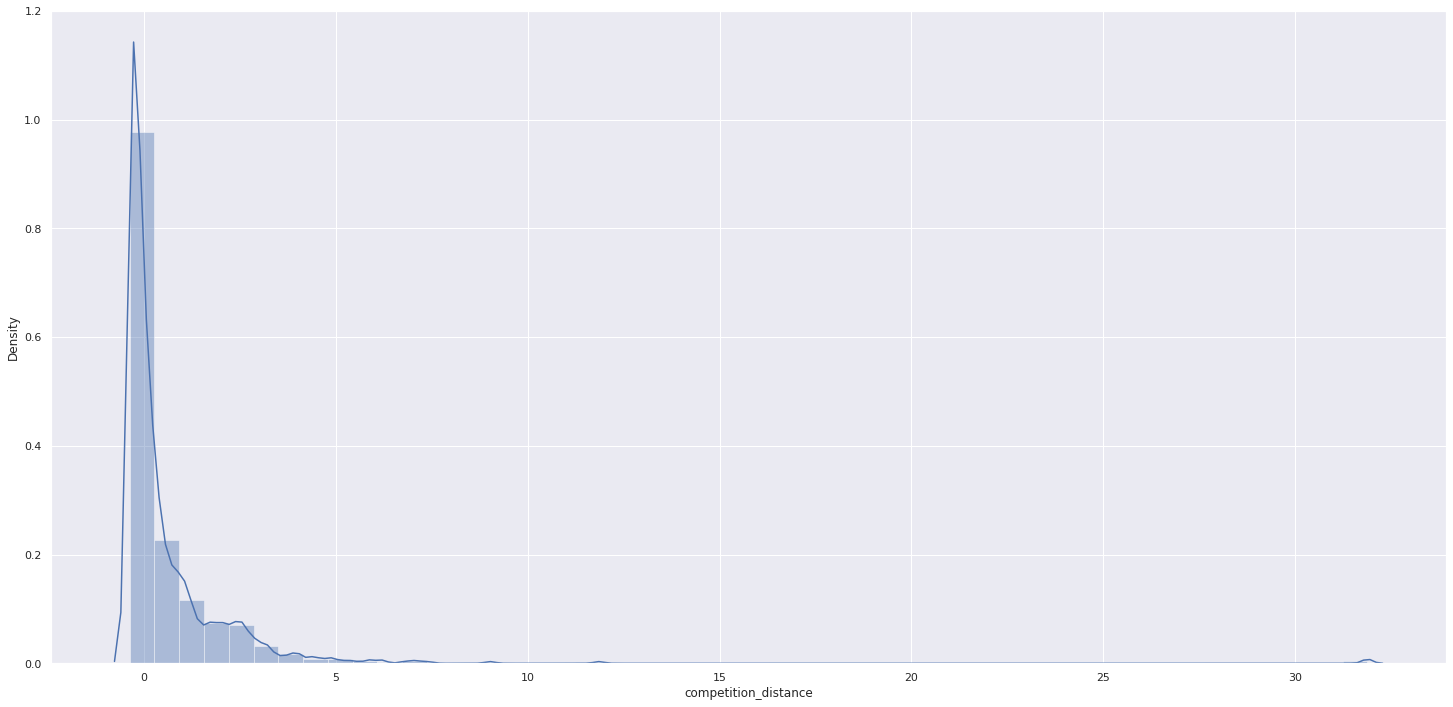

In [89]:
sns.distplot(df5['competition_distance'])

## 5.3 Transformacao

### 5.3.1 Encoding

In [90]:
#state_holiday - One Hot Encoding
df5 = pd.get_dummies(df4,prefix=['state_holiday'],columns=['state_holiday'])

#store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

#assortment - Ordinal Encoding
#basic <  extra < extended 
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3 }
df5['assortment'] = df5['assortment'].map(assortment_dict)


### 5.3.2 Response Variable Transformation

In [91]:
df5['sales'] = np.log1p(df5['sales'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


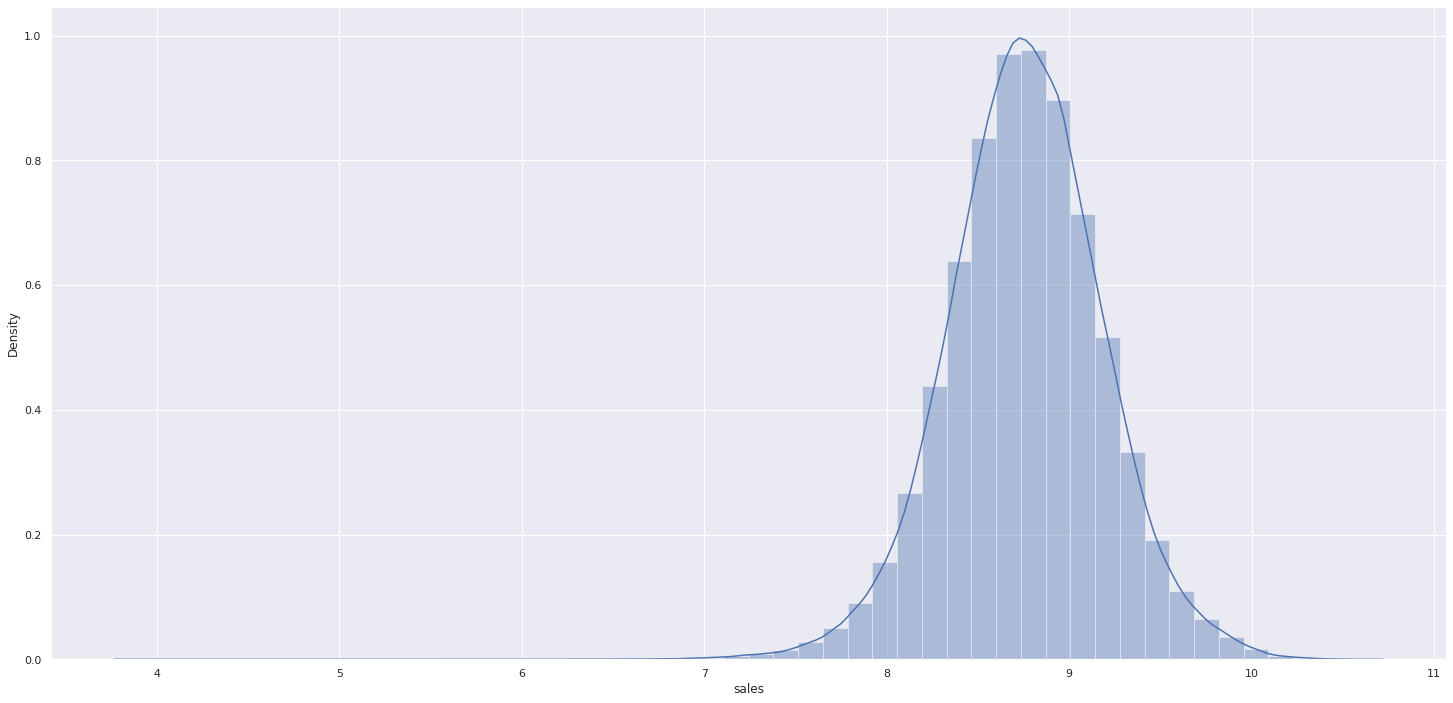

In [92]:
sns.distplot(df5['sales'])

### 5.3.3 Nature Transformation

In [93]:
#variaveis ciclicas
#o 7 indica o tamanho do ciclo(7 dias da semana)
#day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin(x*(2.* np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos(x*(2.* np.pi/7)))


#month
#o doze indica o tamanho do ciclo(12 meses)
df5['month_sin'] = df5['month'].apply( lambda x: np.sin(x*(2.* np.pi/12)))
df5['month_cos'] = df5['month'].apply( lambda x: np.cos(x*(2.* np.pi/12)))

#day
#o 30 indica o tamanho do ciclo(30 dias do mes)
df5['day_sin'] = df5['day'].apply( lambda x: np.sin(x*(2.* np.pi/30)))
df5['day_cos'] = df5['day'].apply( lambda x: np.cos(x*(2.* np.pi/30)))

#week of year
#o 52 indica o tamanho do ciclo(52 semanas do ano)
df5['week_of_year_sin'] = df5['day'].apply( lambda x: np.sin(x*(2.* np.pi/52)))
df5['week_of_year_cos'] = df5['day'].apply( lambda x: np.cos(x*(2.* np.pi/52)))

In [94]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


# 6.0. (Passo 6) FEATURE SELECTION

In [95]:
df6 = df5.copy()

## 6.1 Split dataframe into training and test dataset

In [96]:
df6.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


In [97]:
cols_drop = ['week_of_year','day','month','day_of_week','promo_since','competition_since','year_week']
df6 = df6.drop(cols_drop,axis=1)

In [98]:
#vou separar os ultimos 6 meses para ser os dados de teste
df6[['store','date']].groupby('store').min().reset_index()

,store,date
0,1,2013-01-02
1,2,2013-01-02
2,3,2013-01-02
3,4,2013-01-02
4,5,2013-01-02
5,6,2013-01-02
6,7,2013-01-02
7,8,2013-01-02
8,9,2013-01-02
9,10,2013-01-02


In [99]:

df6[['store','date']].groupby('store').max().reset_index()

,store,date
0,1,2015-07-31
1,2,2015-07-31
2,3,2015-07-31
3,4,2015-07-31
4,5,2015-07-31
5,6,2015-07-31
6,7,2015-07-31
7,8,2015-07-31
8,9,2015-07-31
9,10,2015-07-31


In [100]:
#subtraindo 6 semanas da data maxima
df6[['store','date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days = 6*7)

Timestamp('2015-06-19 00:00:00')

In [101]:
#training dataset
x_train = df6[df6['date'] < '2015-06-19']
X_train = df6[df6['date'] < '2015-06-19']
y_train = x_train['sales']

# test dataset
x_test = df6[df6['date'] >= '2015-06-19']
y_test = x_test['sales']

print('training min date: {}'.format(x_train['date'].min()))
print('training max date: {}'.format(x_train['date'].max()))

print('\ntest min date: {}'.format(x_test['date'].min()))
print('test max date: {}'.format(x_test['date'].max()))


training min date: 2013-01-01 00:00:00
training max date: 2015-06-18 00:00:00

test min date: 2015-06-19 00:00:00
test max date: 2015-07-31 00:00:00


## 6.2 Boruta as Feature Selector

In [102]:
# #training and test dataset for Boruta
# #dropando colunas de teste
# x_train_n = x_train.drop(['date','sales'],axis=1).values
# #ravel coloca tudo dentro de um vetor
# y_train_n = y_train.values.ravel()

# #define RandomForestRegressor, n_jobs = -1 usa todos os cores da maquina e assim faz processamento em paralelo
# rf = RandomForestRegressor (n_jobs = -1)


# # define Boruta
# # classe Boruta, rf = random forest ,verbose = 2 printa o processo,random_state crava o inicio da aleatoriedade, pode ser qualquer numero,x_train_n e y_train_n  são vetores de numero 
# boruta = BorutaPy(rf, n_estimators = 'auto',verbose=2,random_state = 42).fit(x_train_n,y_train_n)

### 6.2.1 Best Features from Boruta

In [103]:
# #suporte é o valor do rank do algoritmo
# cols_selected = boruta.support_.tolist() #vetor de numeros
# x_train_fs = x_train.drop(['date','sales'],axis=1)
# cols_selected_boruta = x_train_fs.iloc[:, cols_selected] #iloc trabalha com index 

### workaround for Boruta

In [104]:
x_train.columns

Index(['store', 'date', 'sales', 'promo', 'school_holiday', 'store_type',
       'assortment', 'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'is_promo', 'year', 'competition_time_month',
       'promo_time_week', 'state_holiday_christmas',
       'state_holiday_easter_holiday', 'state_holiday_public_holiday',
       'state_holiday_regular_day', 'day_of_week_sin', 'day_of_week_cos',
       'month_sin', 'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin',
       'week_of_year_cos'],
      dtype='object')

In [105]:
cols_selected_boruta = ['store',  'promo', 'store_type',
       'assortment', 'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'competition_time_month',
       'promo_time_week','day_of_week_sin', 'day_of_week_cos', 
       'month_cos', 'day_sin', 'day_cos',
       'week_of_year_cos']

In [106]:
#Resumo das hipoteses
# Hipotese | Conclusão | Relevância
# H1         Falsa       Baixa    
# H2         Falsa       Media
# H3         Falsa       Media
# H4         Falsa       Baixa
# H5         -           -
# H7         Falsa       Baixa
# H8         Falsa       Media
# H9         Falsa       Alta
# H10        Falsa       Alta
# H11        Verdadeira  Alta
# H12        Verdadeira  Alta
# H13        Verdadeira  Baixa
#
# Foi visto que na análise exploratoria dos dados o ano é importante , porém para o Boruta não é, nesse caso a desição é do cientista de dados.
# Uma dica como está sendo executada a primeira rodada do Crisp usar o resultado do Boruta
# De forma geral as hipoteses foram confirmadas pelo Boruta


## 6.3. Manual Features Selection

In [107]:
# complementando o seno e cosseno que o boruta deixou de fora
# colocar date e sale que foram retirados, pois vai ser utilizado
cols_selected_boruta = [
    'store',  
    'promo', 
    'store_type',
    'assortment', 
    'competition_distance', 
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2', 'promo2_since_week',
    'promo2_since_year', 
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos', 
    'day_sin', 
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos'
]

#columns to add
feat_to_add = ['date','sales']

#final features
#cols_selected_boruta.extend(feat_to_add)

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)


In [108]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos']

# 7.0. (Passo 7) MACHINE LEARNING MODELLING

In [109]:
x_train = x_train[cols_selected_boruta]
x_test = x_test[cols_selected_boruta]

## 7.1. Average Model

In [110]:
aux1 = x_test.copy()

aux1['sales'] = y_test.copy()
#aux1.head()

#predictions
aux2 = aux1[['store','sales']].groupby('store').mean().reset_index().rename(columns ={'sales':'predctions'})
aux1 = pd.merge(aux1,aux2,how='left',on='store')
#yhat seria o y linha da matematica, que seria uma estimativa
yhat_baseline = aux1['predctions']

#performance
#como foi usado log na seção 5 para a transformação, o exponencial volta ao valor original
baseline_result = ml_error('Average Model',np.expm1(y_test),np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.2064,1835.135542


## 7.2. Linear Regression Model

In [111]:
#model
lr = LinearRegression().fit(x_train, y_train)

#predction
yhat_lr = lr.predict(x_test)

#performance
lr_result = ml_error('Linear Regression',np.expm1(y_test),np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1876.27178,0.293135,2671.34541


In [112]:
# interpretando o resultado acima
# RMSE do modelo de media é 1835.135542 e o de Linear Regression é 2671.34541. O erro de Regressão é muito maior que o modelo de media
# isso significa que o modelo de media é melhor e que os meus dados tem um comportamento complexo não linear e por isso
# modelos lineares não irão conseguir aprender o comportamento do modelo e dessa forma temos que partir para modelos não lineares

#### 7.2.1 Linear Regression Model Cross Validation

In [154]:
lr_result_cv = cross_validation (x_training,5,'Linear Regression',lr,verbose = False)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2068.7 +/- 297.0,0.3 +/- 0.02,2932.12 +/- 465.27


## 7.3. Linear Regression Regularized Model  - Lasso

In [113]:
#model
# alpha é o fator multiplicativo de cada peso
lrr = Lasso(alpha=0.01).fit(x_train, y_train)

#predction
yhat_lrr = lrr.predict(x_test)

#performance
lrr_result = ml_error('Linear Regression - Lasso',np.expm1(y_test),np.expm1(yhat_lrr))
lrr_result

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.345e+02, tolerance: 1.455e+01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1890.285926,0.294716,2720.25433


In [114]:
#interpretando o resultado de cima
# da pra ver que o RMSE foi pior que o Linear Regression, diminuindo o alpha pode melorar mas demora mais algo em torno de 0.00001


#### 7.3.1 Linear Regression Regularized Model  (Lasso )Cross Validation





In [155]:
lrr_result_cv = cross_validation (x_training,5,'Lasso',lrr,verbose = False)
lrr_result_cv

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.667e+01, tolerance: 1.194e+01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.783e+02, tolerance: 1.392e+01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2113.02 +/- 343.97,0.29 +/- 0.01,3047.59 +/- 509.63


### 7.4. Random Forest Regressor

In [115]:
#model
#n_estimator quantas arvores serão criada, n_jobs = -1 para rodar em paralelo e random_state = 42 origem dos numeros aleatorios ( pode ser qualquer numero), é um numero aleatorio para se iniciar a aleatoriedade
rf = RandomForestRegressor(n_estimators=100,n_jobs= -1, random_state=42).fit(x_train, y_train)

#predction
yhat_rf = rf.predict(x_test)

#performance
rf_result = ml_error('Random Forest Regressor',np.expm1(y_test),np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,692.157653,0.103049,1025.797568


#### 7.4.1 Random Forest Regression Cross Validation





In [156]:
rf_result_cv = cross_validation (x_training,5,'Random Forest',rf,verbose = True)
rf_result_cv


 KFold Number: 5

 KFold Number: 4

 KFold Number: 3

 KFold Number: 2

 KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest,850.02 +/- 230.95,0.12 +/- 0.02,1269.92 +/- 328.94


### 7.5. XGBoost Regressor

In [116]:
#model

# objective função objetiva, eta  quantas passadas ele usa para fazer o aprendizado, max_depth profundidade maxima que a arvore pode chegar
# demais ler a documentação, sera usado valores padrão
model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=100,
                             eta=0.01,
                             max_depth=10,
                             subsample=0.7,
                             colsample_bytree=0.9).fit(x_train, y_train)

#predction
yhat_xgb = model_xgb.predict(x_test)

#performance
xgb_result = ml_error('XGBoost Regressor',np.expm1(y_test),np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,874.192249,0.128217,1284.222947


#### 7.5.1 XGBoost Regressor - Cross Validation





In [ ]:
xgb_result_cv = cross_validation (x_training,5,'XGBoost Regressor',model_xgb,verbose = True)
xgb_result_cv


 KFold Number: 5

 KFold Number: 4


### 7.6. Compare Model's Performance

#### 7.6.1 Single Performance

In [117]:
modelling_result = pd.concat([baseline_result,lr_result,lrr_result,rf_result,xgb_result])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,692.157653,0.103049,1025.797568
0,XGBoost Regressor,874.192249,0.128217,1284.222947
0,Average Model,1354.800353,0.206400,1835.135542
0,Linear Regression,1876.271780,0.293135,2671.345410
0,Linear Regression - Lasso,1890.285926,0.294716,2720.254330


In [118]:
#interpretação dos resultado
# o fenomeno que esta sendo modelado é complexo e modelos lineares não funcionam muito bem, 
# Random Forest e XGBoost funcionam bem.
# Olhando a tabela gerada na celula acima olhando o erro RMSE diriamos que a Random Forest é o melhor, porém isso é errado
#os modelos não podem ser avaliados só pelas ultimas 6 semanas que é o caso. O certo é usar o cross validation ( pegar semanas aleatorias)

In [119]:
x_training =  X_train[cols_selected_boruta_full]


In [149]:
model = Lasso(alpha=0.01)
a = cross_validation(x_training,5, 'Lasso', model)


 KFold Number: 5

 KFold Number: 4


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.667e+01, tolerance: 1.194e+01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive



 KFold Number: 3

 KFold Number: 2

 KFold Number: 1


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.783e+02, tolerance: 1.392e+01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


In [150]:
a

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2113.02 +/- 343.97,0.29 +/- 0.01,3047.59 +/- 509.63


#### 7.6.2 Real Performance - Cross Validation

In [ ]:
modelling_result_cv = pd.concat([lr_result_cv,lrr_result_cv,rf_result_cv,xgb_result_cv])
modelling_result_cv.sort_values('RMSE')

In [ ]:
# Olhando os resultados a random forest performou melhor que os demais seguido de XGBoost.
# Porém no treinamento sera usado o XGBoost pelo fato que vem ganhando fama no kagle enão tem muita coisa pronta na internet diferentemente da random forest